- `pandas`: For data manipulation.
- `os`: To get the file path for reading CSV files.
- `matplotlib.pyplot` (`plt`): For creating plots.
- `seaborn` (`sns`): For creating plots.
- `prophet`: For making time series predictions.
- `sklearn`: For validating time series models.
- `numpy`: For MAPE (Mean Absolute Percentage Error) calculation.

In [1]:
#IMPORTING ALL THE REQUIRED LIBRARIES
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

C:\Users\krish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
current_directory = os.getcwd()
file_name1 = "countries.csv"
file_name2 = "industries.csv"
file_name3 = "payouts.csv"

#making filepaths 
file_path1 = os.path.join(current_directory, "data", file_name1)
file_path2 = os.path.join(current_directory, "data", file_name2)
file_path3 = os.path.join(current_directory, "data", file_name3)

# READING THE CSV fileS
countries = pd.read_csv(file_path1)
industries = pd.read_csv(file_path2)
payouts = pd.read_csv(file_path3)

In [3]:
# Display the first few rows of the dataframe
countries.head()

,merchant_id,country
0,id_ace715763434d4fd4eda58c9e9d692c6,FR
1,id_717b4a0f74912f18146c0708b330a3d9,US
2,id_671fd54bccd294b502fea89c0cc5a690,US
3,id_d8ed94b4e446b868e38efa8efa34b702,FR
4,id_1a054e523cbf203b16b38fc3e5b19b25,US


In [4]:
industries.head()

,merchant_id,industry
0,id_ace715763434d4fd4eda58c9e9d692c6,Travel & Hospitality
1,id_717b4a0f74912f18146c0708b330a3d9,Food & Beverage
2,id_671fd54bccd294b502fea89c0cc5a690,Professional Services (non-medical)
3,id_d8ed94b4e446b868e38efa8efa34b702,Travel & Hospitality
4,id_1a054e523cbf203b16b38fc3e5b19b25,Professional Services (non-medical)


In [5]:
payouts.tail()

,date,platform_id,recipient_id,count,amount
1622637,2018-08-02 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_e4dff590a6728c8c27a35203f9443c58,1,26284.0
1622638,2018-12-18 00:00:00+00:00,id_4fbd94bb830c62816abb07d6544bd707,id_c37e45a5b586f8fda03482b553885e81,1,8632.0
1622639,2018-04-04 00:00:00+00:00,id_296420e88b94f7b67b7bb305ac82a0e4,id_e027ff25aae5b91268d99907710de5c1,1,33243.0
1622640,2018-07-19 00:00:00+00:00,id_48ba75d17cfea6d24ca5ba8dd72559a0,id_39a6f54346d9c62050ea03fad9693f8f,1,11882.0
1622641,2018-06-28 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_a1cb4fd279e0cee8f9d990a8113125cb,1,76200.0


# Q1) Using the data provided, please provide an estimate for the amount of money we should expect to be paid out to each country on Jan. 1, 2019 (the day after the last day in the dataset).

<b>Steps in the Analysis
- payout is recieved by recipient so if we want to see how much payouts a country get then will have to tag recipient id to the country 
- 1)checking Missing values in payouts and country tables
- 2)Checking whether all recipient_ids have a country associated with it(if it's significant then it will need special treatment)
- 3)checking mix of payouts by country
- 4)checking trends and fitting prophet model for the major countries, we change amount to $ here from cents
- 5)checking for anomalies for rest of the countries and comment on if it's fine
- 6)wrap up 1st Qn

1)checking Missing/abnormal values in payouts and country tables 

In [6]:
payouts.isnull().sum()

date            0
platform_id     0
recipient_id    0
count           0
amount          0
dtype: int64

In [7]:
countries.isnull().sum()

merchant_id    0
country        0
dtype: int64

In [8]:
payouts['date'].min(), payouts['date'].max()

('2018-01-01 00:00:00+00:00', '2018-12-31 00:00:00+00:00')

In [9]:
payouts['amount'].min(),payouts['amount'].max() 

(-26139110.0, 398161806.0)

In [10]:
#2649 payouts are negative, Assuming it's a normal behaviour as there could be reversals of transactions we don't take any action
payouts[payouts['amount']<0]

,date,platform_id,recipient_id,count,amount
581,2018-07-15 00:00:00+00:00,id_84202f58ad6f8b83411d51e8e1062d72,id_c74e457211263d9b8a923858853c7ba6,1,-5424.0
664,2018-12-21 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_7b0cbab050b944b48a8c485478579182,1,-345.0
1252,2018-05-09 00:00:00+00:00,id_84202f58ad6f8b83411d51e8e1062d72,id_0c4d1ee4c9ea6068399ffb327f9c80ba,1,-156502.0
1350,2018-11-22 00:00:00+00:00,id_88a1499bc0a213528ab6d224a1ad208e,id_254368f58342af2fdc79ff7b14bf80e8,2,-50501.0
2163,2018-03-30 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_d013666eeace45f37e2a9a833a5004e8,1,-4972.0
...,...,...,...,...,...
1619954,2018-10-17 00:00:00+00:00,id_6c3d0818bcd7b799073908c5ba35eccf,id_fffe8c4caf734841d733338a7ed2a63f,1,-25573.0
1620135,2018-07-22 00:00:00+00:00,id_84202f58ad6f8b83411d51e8e1062d72,id_6eaf9130dba89a9b5f7dd37c28c8bac9,1,-27107.0
1620863,2018-11-08 00:00:00+00:00,id_4a7970ec57a6252a1048a577145baaa4,id_b7e67155aa52e9bf75ee31b433068f51,1,-172260.0
1620912,2018-11-25 00:00:00+00:00,id_6c3d0818bcd7b799073908c5ba35eccf,id_36c8ae06949b1cbcb9bb57c6afd4f979,1,-13065.0


2)Checking whether all recipient_ids have a country associated with it(if it's significant then it will need special treatment)

In [11]:
distinct_recipients_count = payouts['recipient_id'].nunique()
distinct_merchants_count = countries['merchant_id'].nunique()
matching_merchants_count = payouts[payouts['recipient_id'].isin(countries['merchant_id'])]['recipient_id'].nunique()
non_matching_merchants = payouts[~payouts['recipient_id'].isin(countries['merchant_id'])]
non_matching_merchants_count = non_matching_merchants['recipient_id'].nunique()
non_matching_merchants_amount = non_matching_merchants['amount'].sum() / 100  


print(f"Distinct recipients count: {distinct_recipients_count}")
print(f"Distinct merchants count: {distinct_merchants_count}")
print(f"Matching merchants with a country code count: {matching_merchants_count}")
print(f"merchants without a country code count: {non_matching_merchants_count}")
print(f"Total payout for merchants without a country code count: in cents {non_matching_merchants_amount:,.2f}")
print(f"Total payout for merchants without a country code count as % of total: {non_matching_merchants_amount*100.00/payouts['amount'].sum():,.5f}%")

Distinct recipients count: 112030
Distinct merchants count: 112309
Matching merchants with a country code count: 102120
merchants without a country code count: 9910
Total payout for merchants without a country code count: in cents 4,305,672.22
Total payout for merchants without a country code count as % of total: 0.00320%


Here we can see 9910 recipient_id are not tagged a country in the countries dataset, the total payout volumne of these are ~$43K but it's only 0.00320% of total payouts and hence we are ignoring it 

 3)checking mix of payouts by country

In [12]:
#merging countries and payouts, inner as we're ignoring recipient_ids which aren't in countries(as payout volume is low)
df_fnl = pd.merge(payouts, countries, left_on='recipient_id', right_on='merchant_id')

In [13]:
total_payouts_by_country = df_fnl.groupby('country')['amount'].sum()
total_payouts = total_payouts_by_country.sum()
percentage_mix = (total_payouts_by_country / total_payouts) * 100
percentage_mix.sort_values(ascending=False)

country
US    93.047258
CA     1.616534
GB     1.387952
FR     1.282084
AU     0.786867
JP     0.334522
HK     0.257825
ES     0.193210
DE     0.160771
IE     0.124289
SG     0.116090
BE     0.108221
NZ     0.098850
BR     0.075186
SE     0.071664
FI     0.070592
NO     0.058135
IT     0.057007
NL     0.043040
DK     0.034029
AT     0.029497
CH     0.016239
MX     0.015819
PT     0.011995
LU     0.002324
Name: amount, dtype: float64

As we can see 93% of the PayOuts are from US , So while fittng prophet model we will optimize for US more

<b>4)checking trends and fitting prophet model for the major countries, we change amount to $ here from cents.

In [14]:
#preparing data, we need day and country wise aggregated payout data for prediction finally , converting cents to $ by dividing by 100
df_fnl['date_d'] = pd.to_datetime(df_fnl['date']).dt.date
df_grouped = df_fnl.groupby(['country', 'date_d'])['amount'].sum().sort_values(ascending=False).reset_index()
df_grouped['amount']=df_grouped['amount']/100

Creating a fuction so that we can automate the process of seeing trends for major countries 

In [15]:
def plot_country_trend(df, country_name, date_column='date', amount_column='amount'):
    # Filter the DataFrame for the given country
    country_df = df[df['country'] == country_name]
    
    # Convert the date column to datetime if it isn't already
    country_df[date_column] = pd.to_datetime(country_df[date_column])
    
    # Aggregate the amounts by date
    country_df = country_df.groupby(date_column)[amount_column].sum().reset_index()
    
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.plot(country_df[date_column], country_df[amount_column], label=country_name, linewidth=2)
    plt.title(f'Trend of Amount by Date for {country_name}')
    plt.xlabel('Date')
    plt.ylabel('Total Amount')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

country
US    93.047258
CA     1.616534
GB     1.387952
FR     1.282084
AU     0.786867
JP     0.334522
HK     0.257825
ES     0.193210
DE     0.160771
IE     0.124289
SG     0.116090
BE     0.108221
NZ     0.098850
BR     0.075186
SE     0.071664
FI     0.070592
NO     0.058135
IT     0.057007
NL     0.043040
DK     0.034029
AT     0.029497
CH     0.016239
MX     0.015819
PT     0.011995
LU     0.002324


C:\Users\krish\AppData\Local\Temp\ipykernel_26448\300289286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df[date_column] = pd.to_datetime(country_df[date_column])


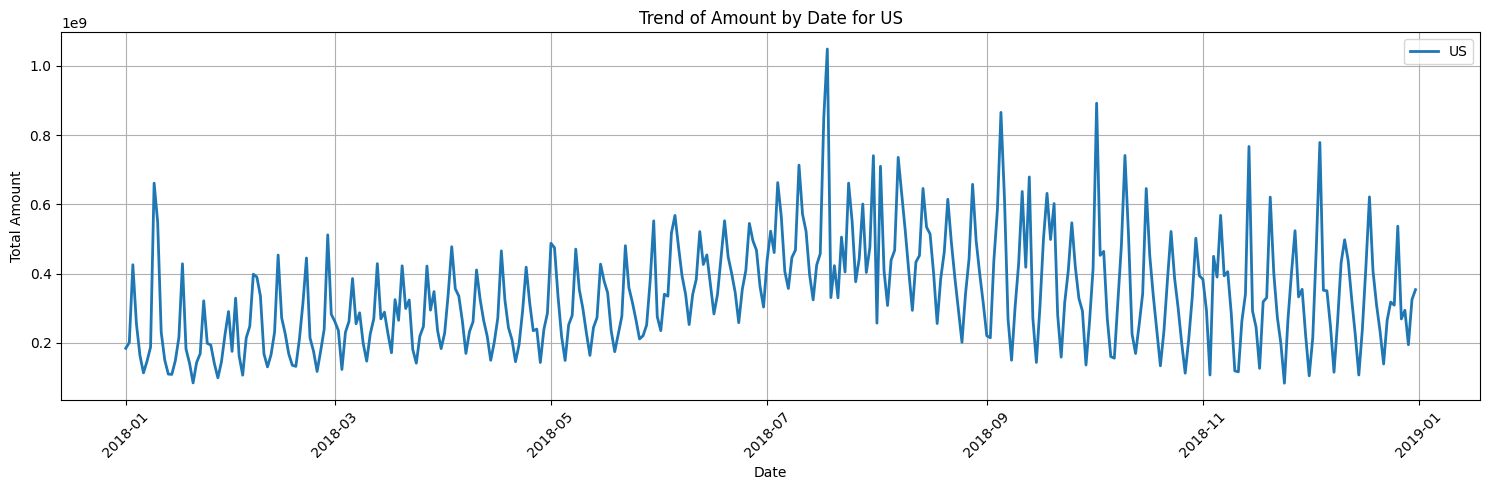

In [16]:
#Let's see US first
plot_country_trend(df_fnl, 'US', date_column='date_d', amount_column='amount')

C:\Users\krish\AppData\Local\Temp\ipykernel_26448\300289286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df[date_column] = pd.to_datetime(country_df[date_column])


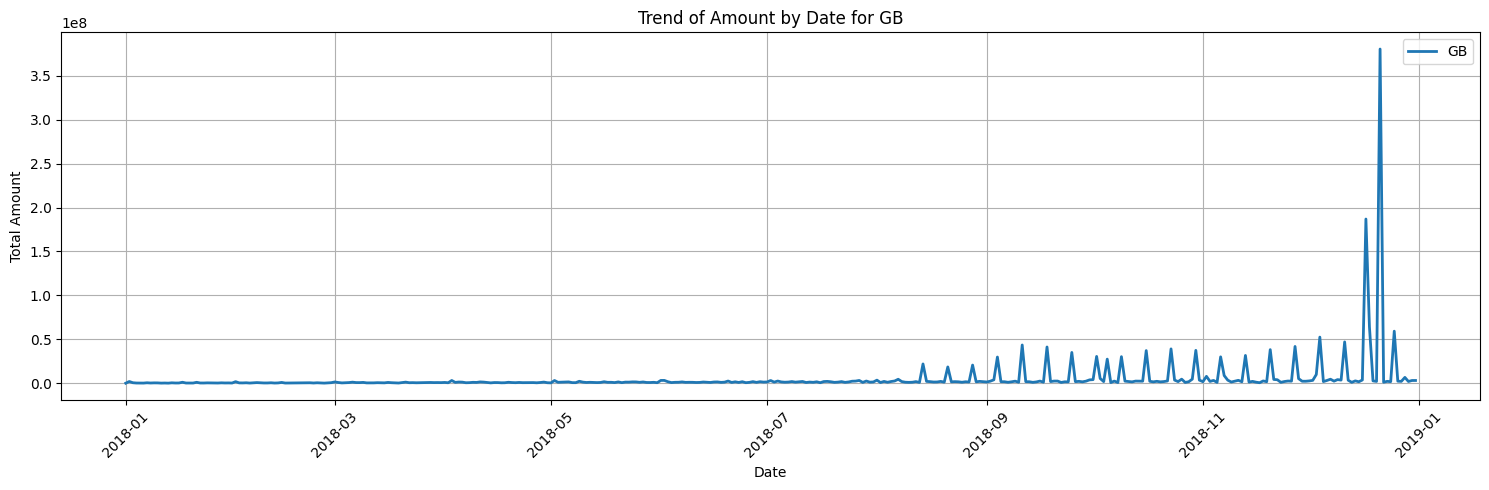

In [17]:
plot_country_trend(df_fnl, 'GB', date_column='date_d', amount_column='amount')

C:\Users\krish\AppData\Local\Temp\ipykernel_26448\300289286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df[date_column] = pd.to_datetime(country_df[date_column])


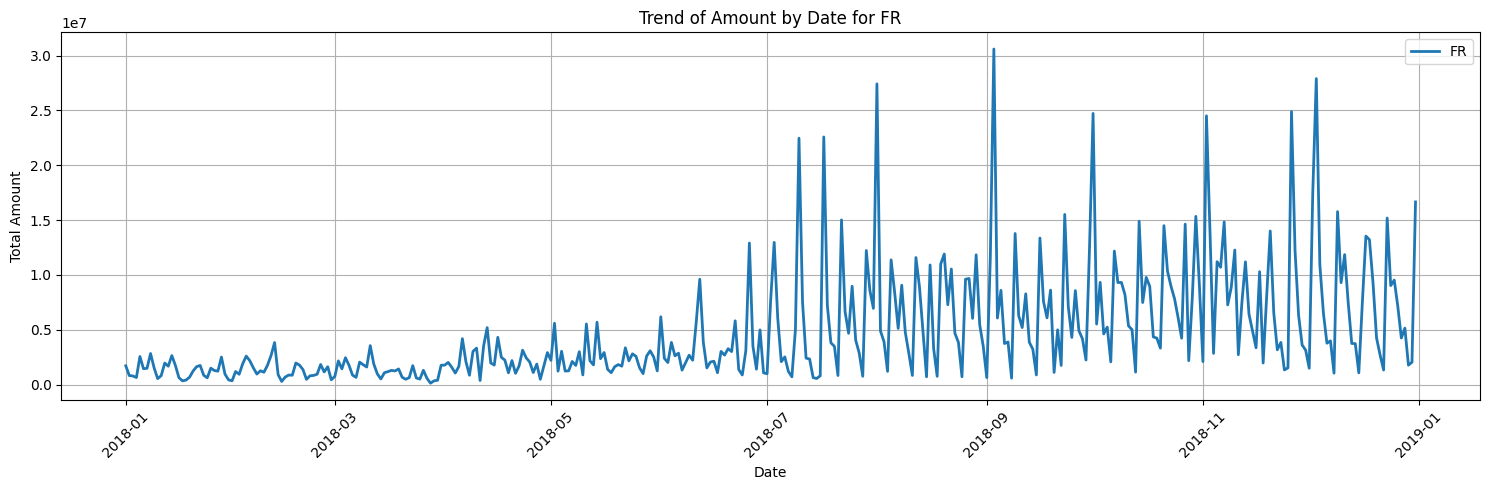

In [18]:
plot_country_trend(df_fnl, 'FR', date_column='date_d', amount_column='amount')

C:\Users\krish\AppData\Local\Temp\ipykernel_26448\300289286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df[date_column] = pd.to_datetime(country_df[date_column])


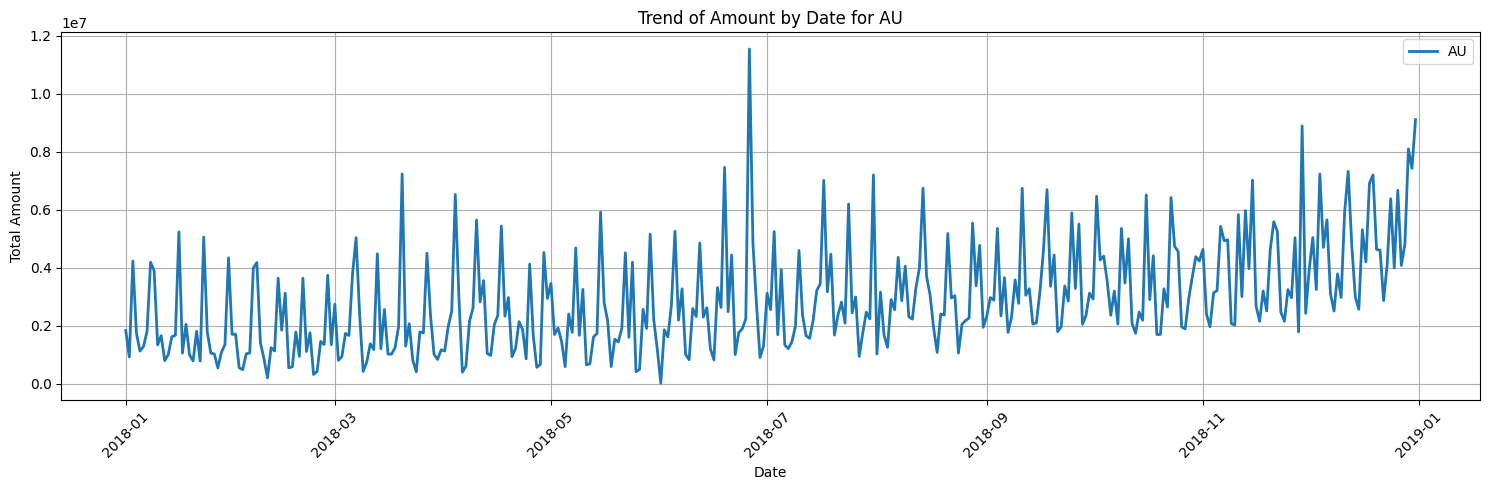

In [19]:
plot_country_trend(df_fnl, 'AU', date_column='date_d', amount_column='amount')

C:\Users\krish\AppData\Local\Temp\ipykernel_26448\300289286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df[date_column] = pd.to_datetime(country_df[date_column])


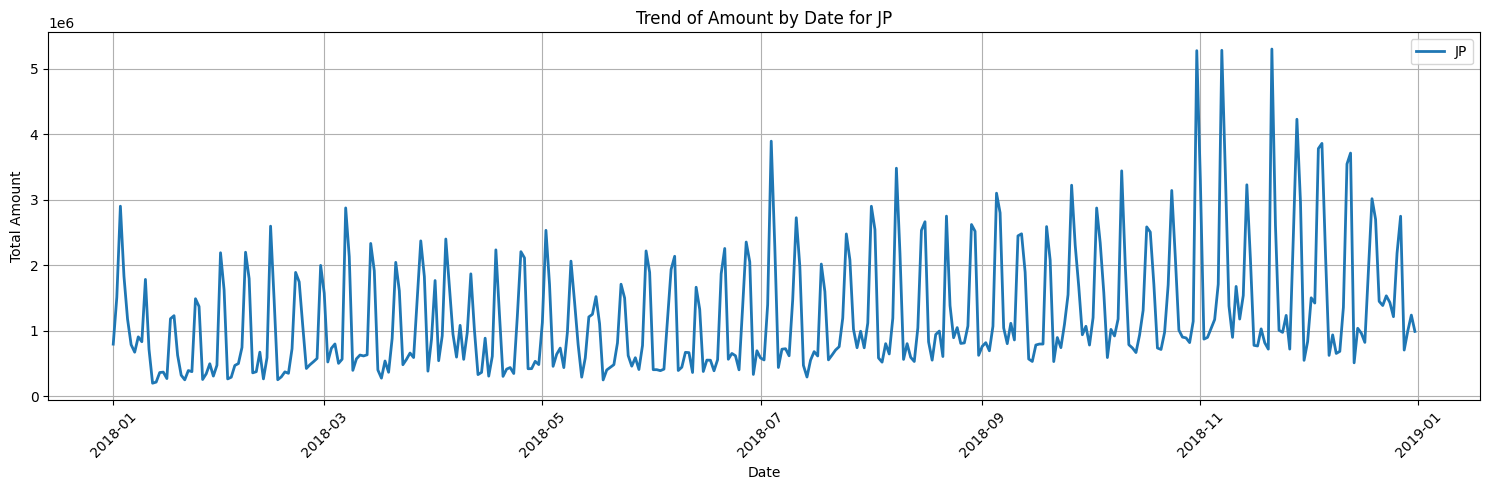

In [20]:
plot_country_trend(df_fnl, 'JP', date_column='date_d', amount_column='amount')

From GB and FR plots we can see that some countries have low payouts in H1'18. I'll first try to fit a prophet model and see the mape/mae/rmse for it on US. we will adjust it then iteratively to fit other countries
- I'm using FB Prophet to make the predictions, I've used it previously and have seen it give better results than ARIMA and hence trying it
- for the fit iteration I'm trying by a plain model.fit() without using any seasonality parameters(model adjust parameter based on data ), we can then iterate

In [21]:
def model_and_plot(df_grouped, country_name):
    # Prepare the data
    df_grouped['date_d'] = pd.to_datetime(df_grouped['date_d'])
    df_country = df_grouped[df_grouped['country'] == country_name][['date_d', 'amount']].rename(columns={'date_d': 'ds', 'amount': 'y'})
    df_train = df_country[df_country['ds'] < '2018-12-01']
    df_test = df_country[(df_country['ds'] >= '2018-12-01') & (df_country['ds'] < '2019-01-01')]

    # Train the model
    # model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
    model=Prophet()
    model.fit(df_train)

    # Make predictions
    df_test_forecast = model.predict(df_test[['ds']])
    df_test_forecast = df_test_forecast.sort_values('ds')

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(df_test['y'], df_test_forecast['yhat']))
    mae = mean_absolute_error(df_test['y'], df_test_forecast['yhat'])
    mape = np.mean(np.abs((df_test['y'] - df_test_forecast['yhat']) / df_test['y'])) * 100

    # Print performance metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"Model Components: {model.component_modes}")

    # Forecast for a future date
    future = pd.DataFrame(['2019-01-01'], columns=['ds'])
    future['ds'] = pd.to_datetime(future['ds'])
    forecast = model.predict(future)
    print(f"Forecast for January 1, 2019: {forecast['yhat'].iloc[0]}")

    # Plotting the results
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df_train['ds'], df_train['y'], color='g', label='Actual (Train)')
    ax.scatter(df_test['ds'], df_test['y'], color='r', label='Actual (Test)')
    ax.plot(df_test_forecast['ds'], df_test_forecast['yhat'], color='b', label='Forecast')

    # Set labels and legend
    ax.set_title(f'Prophet Model Forecast vs Actual for {country_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Payout Amount')
    ax.legend()

    # Show the plot
    plt.show()

19:40:03 - cmdstanpy - INFO - Chain [1] start processing
19:40:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1816967.430418662
MAE: 1331325.4850583998
MAPE: 63.35424482040335
Model Components: {'additive': ['weekly', 'additive_terms', 'extra_regressors_additive', 'holidays'], 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}
Forecast for January 1, 2019: 4466374.49844499


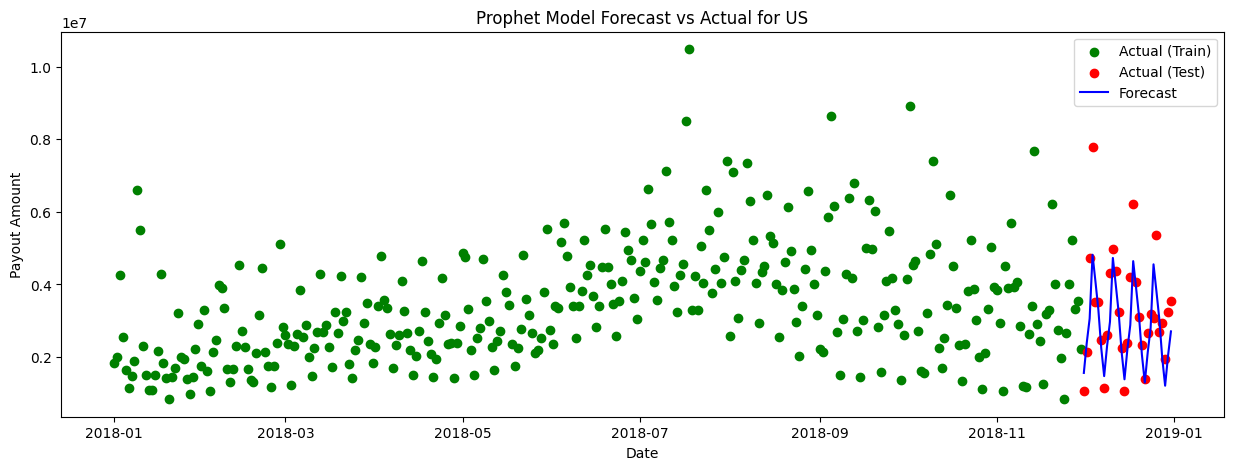

In [22]:
model_and_plot(df_grouped, 'US')

Checking the components of prophet , we see that only weekly trend is captured and hence daily fluctuations aren't captured, plus the peaks are not captured well 
- so I'm updating the model to add more trends with daily trend and seasonality as multiplicative

In [23]:
def model_and_plot_updated(df_grouped, country_name):
    # Prepare the data
    df_grouped['date_d'] = pd.to_datetime(df_grouped['date_d'])
    df_country = df_grouped[df_grouped['country'] == country_name][['date_d', 'amount']].rename(columns={'date_d': 'ds', 'amount': 'y'})
    df_train = df_country[df_country['ds'] < '2018-12-01']
    df_test = df_country[(df_country['ds'] >= '2018-12-01') & (df_country['ds'] < '2019-01-01')]

    # Train the model
    model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
    # model=Prophet()
    model.fit(df_train)

    # Make predictions
    df_test_forecast = model.predict(df_test[['ds']])
    df_test_forecast = df_test_forecast.sort_values('ds')
    df_test = df_test.sort_values('ds').reset_index()

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(df_test['y'], df_test_forecast['yhat']))
    mae = mean_absolute_error(df_test['y'], df_test_forecast['yhat'])
    mape = np.mean(np.abs((df_test['y'] - df_test_forecast['yhat']) / df_test['y'])) * 100

    # Print performance metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"Model Components: {model.component_modes}")

    # Forecast for a future date
    future = pd.DataFrame(['2019-01-01'], columns=['ds'])
    future['ds'] = pd.to_datetime(future['ds'])
    forecast = model.predict(future)
    print(f"Forecast for January 1, 2019: {forecast['yhat'].iloc[0]}")

    # Plotting the results
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df_train['ds'], df_train['y'], color='g', label='Actual (Train)')
    ax.scatter(df_test['ds'], df_test['y'], color='r', label='Actual (Test)')
    ax.plot(df_test_forecast['ds'], df_test_forecast['yhat'], color='b', label='Forecast')

    # Set labels and legend
    ax.set_title(f'Prophet Model Forecast vs Actual for {country_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Payout Amount')
    ax.legend()

    # Show the plot
    plt.show()

19:40:04 - cmdstanpy - INFO - Chain [1] start processing
19:40:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 989584.8471085334
MAE: 702967.2215529694
MAPE: 21.29473691712061
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 4005293.319484806


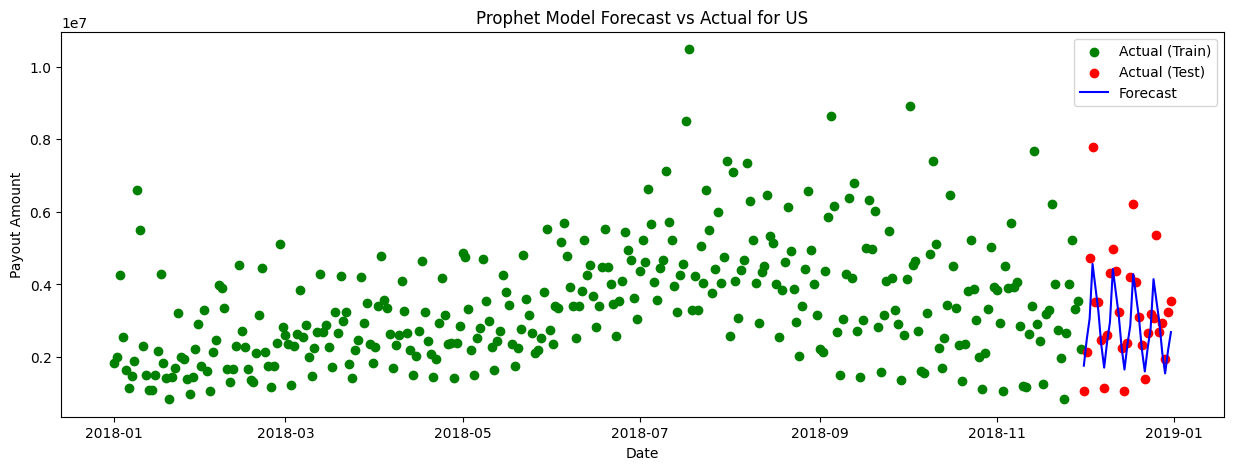

In [24]:
model_and_plot_updated(df_grouped, 'US')

The predictions look better and mape is also low so I'm keeping the parameters and let's see what's the predictions for other countries

In [25]:
summary_results = pd.DataFrame(columns=['Country', 'MAPE', 'Forecast for January 1, 2019'])
rows_list = []

for country in df_grouped['country'].unique():
    df_country = df_grouped[df_grouped['country'] == country][['date_d', 'amount']].rename(columns={'date_d': 'ds', 'amount': 'y'})
    
    df_train = df_country[df_country['ds'] < '2018-12-01']
    df_test = df_country[(df_country['ds'] >= '2018-12-01') & (df_country['ds'] < '2019-01-01')]
    
    model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True,seasonality_mode='multiplicative')
    model.fit(df_train)

    df_test_forecast = model.predict(df_test[['ds']])
    df_test = df_test.sort_values('ds').reset_index()
    df_test_forecast = df_test_forecast.sort_values('ds')
    
    mape = np.mean(np.abs((df_test['y'] - df_test_forecast['yhat']) / df_test['y'])) * 100
    
    future = pd.DataFrame(['2019-01-01'], columns=['ds'])
    future['ds'] = pd.to_datetime(future['ds'])
    forecast = model.predict(future)
    forecast_value = forecast['yhat'].iloc[0]

    new_row = {'Country': country, 'MAPE': mape, 'Forecast for January 1, 2019': forecast_value}
    rows_list.append(new_row)    

    
summary_results = pd.concat([summary_results, pd.DataFrame(rows_list)], ignore_index=True)
# Display the summary results
print(summary_results)

19:40:05 - cmdstanpy - INFO - Chain [1] start processing
19:40:05 - cmdstanpy - INFO - Chain [1] done processing


19:40:05 - cmdstanpy - INFO - Chain [1] start processing
19:40:05 - cmdstanpy - INFO - Chain [1] done processing
19:40:05 - cmdstanpy - INFO - Chain [1] start processing
19:40:05 - cmdstanpy - INFO - Chain [1] done processing
19:40:05 - cmdstanpy - INFO - Chain [1] start processing
19:40:06 - cmdstanpy - INFO - Chain [1] done processing
19:40:06 - cmdstanpy - INFO - Chain [1] start processing
19:40:06 - cmdstanpy - INFO - Chain [1] done processing
19:40:06 - cmdstanpy - INFO - Chain [1] start processing
19:40:06 - cmdstanpy - INFO - Chain [1] done processing
19:40:06 - cmdstanpy - INFO - Chain [1] start processing
19:40:06 - cmdstanpy - INFO - Chain [1] done processing
19:40:06 - cmdstanpy - INFO - Chain [1] start processing
19:40:07 - cmdstanpy - INFO - Chain [1] done processing
19:40:07 - cmdstanpy - INFO - Chain [1] start processing
19:40:07 - cmdstanpy - INFO - Chain [1] done processing
19:40:07 - cmdstanpy - INFO - Chain [1] start processing
19:40:07 - cmdstanpy - INFO - Chain [1]

   Country         MAPE  Forecast for January 1, 2019
0       US    21.294737                  4.005293e+06
1       GB    38.834610                  3.644539e+05
2       FR   102.356751                  1.322099e+05
3       HK   177.522464                  4.270580e+03
4       CA    37.849857                  4.301945e+04
5       DE   553.794061                  1.467895e+05
6       AU    31.218548                  7.399008e+04
7       ES   265.636662                  7.696124e+04
8       FI   125.647245                  4.295879e+03
9       NZ   221.702546                  1.354697e+04
10      MX  1794.264905                 -3.816107e+03
11      NO   195.908548                  3.123277e+03
12      JP    35.125890                  1.846608e+04
13      SG    70.537505                  1.036495e+03
14      IE    52.725701                  1.407706e+04
15      IT   961.914820                  3.547068e+04
16      BE    54.865897                  6.612807e+03
17      BR    53.932657     

C:\Users\krish\AppData\Local\Temp\ipykernel_26448\504852649.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_results = pd.concat([summary_results, pd.DataFrame(rows_list)], ignore_index=True)


since summary_results had some high MAPE countries, let's add no of data training data points to summary results to see if it's due to insufficient training data

In [26]:
summary_results = pd.DataFrame(columns=['Country', 'MAPE', 'Forecast for January 1, 2019'])
rows_list = []

for country in df_grouped['country'].unique():
    df_country = df_grouped[df_grouped['country'] == country][['date_d', 'amount']].rename(columns={'date_d': 'ds', 'amount': 'y'})
    
    df_train = df_country[df_country['ds'] < '2018-12-01']
    df_test = df_country[(df_country['ds'] >= '2018-12-01') & (df_country['ds'] < '2019-01-01')]
    
    model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True,seasonality_mode='multiplicative')
    model.fit(df_train)

    df_test_forecast = model.predict(df_test[['ds']])
    df_test = df_test.sort_values('ds').reset_index()
    df_test_forecast = df_test_forecast.sort_values('ds')
    
    mape = np.mean(np.abs((df_test['y'] - df_test_forecast['yhat']) / df_test['y'])) * 100
    
    future = pd.DataFrame(['2019-01-01'], columns=['ds'])
    future['ds'] = pd.to_datetime(future['ds'])
    forecast = model.predict(future)
    forecast_value = forecast['yhat'].iloc[0]
    data_points = len(df_train)

    new_row = {
    'Country': country,
    'MAPE': mape,
    'Forecast for January 1, 2019': forecast_value,
    'Data Points in Training': data_points  
    }
    rows_list.append(new_row)    

    
summary_results = pd.concat([summary_results, pd.DataFrame(rows_list)], ignore_index=True)
# Display the summary results
summary_results

19:40:10 - cmdstanpy - INFO - Chain [1] start processing
19:40:10 - cmdstanpy - INFO - Chain [1] done processing


19:40:10 - cmdstanpy - INFO - Chain [1] start processing
19:40:10 - cmdstanpy - INFO - Chain [1] done processing
19:40:11 - cmdstanpy - INFO - Chain [1] start processing
19:40:11 - cmdstanpy - INFO - Chain [1] done processing
19:40:11 - cmdstanpy - INFO - Chain [1] start processing
19:40:11 - cmdstanpy - INFO - Chain [1] done processing
19:40:11 - cmdstanpy - INFO - Chain [1] start processing
19:40:11 - cmdstanpy - INFO - Chain [1] done processing
19:40:11 - cmdstanpy - INFO - Chain [1] start processing
19:40:11 - cmdstanpy - INFO - Chain [1] done processing
19:40:11 - cmdstanpy - INFO - Chain [1] start processing
19:40:11 - cmdstanpy - INFO - Chain [1] done processing
19:40:12 - cmdstanpy - INFO - Chain [1] start processing
19:40:12 - cmdstanpy - INFO - Chain [1] done processing
19:40:12 - cmdstanpy - INFO - Chain [1] start processing
19:40:12 - cmdstanpy - INFO - Chain [1] done processing
19:40:12 - cmdstanpy - INFO - Chain [1] start processing
19:40:12 - cmdstanpy - INFO - Chain [1]

,Country,MAPE,"Forecast for January 1, 2019",Data Points in Training
0,US,21.294737,4.005293e+06,334.0
1,GB,38.834610,3.644539e+05,334.0
2,FR,102.356751,1.322099e+05,334.0
3,HK,177.522464,4.270580e+03,281.0
4,CA,37.849857,4.301945e+04,334.0
5,DE,553.794061,1.467895e+05,332.0
6,AU,31.218548,7.399008e+04,334.0
7,ES,265.636662,7.696124e+04,334.0
8,FI,125.647245,4.295879e+03,222.0
9,NZ,221.702546,1.354697e+04,256.0


As we can see, MX showing negative value and LU showing highest mape have very less number of training data, as for other let's deep dive and see if it's fixable

19:40:15 - cmdstanpy - INFO - Chain [1] start processing
19:40:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 46485.197537384316
MAE: 37930.248112843656
MAPE: 102.35675072850015
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 132209.94405359795


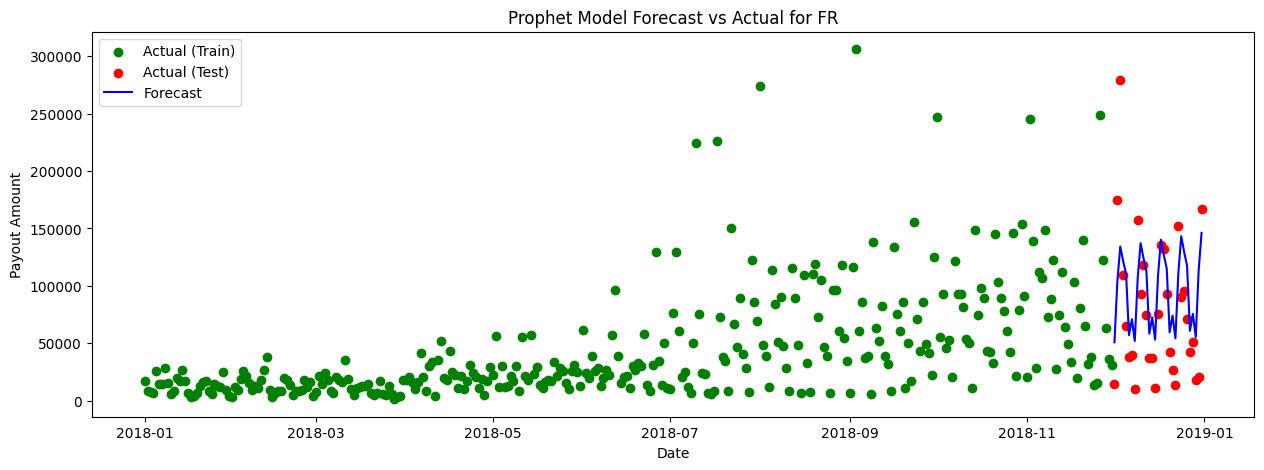

19:40:16 - cmdstanpy - INFO - Chain [1] start processing
19:40:16 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 4505.758845035771
MAE: 3648.917044740921
MAPE: 177.52246424605255
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 4270.579956082828


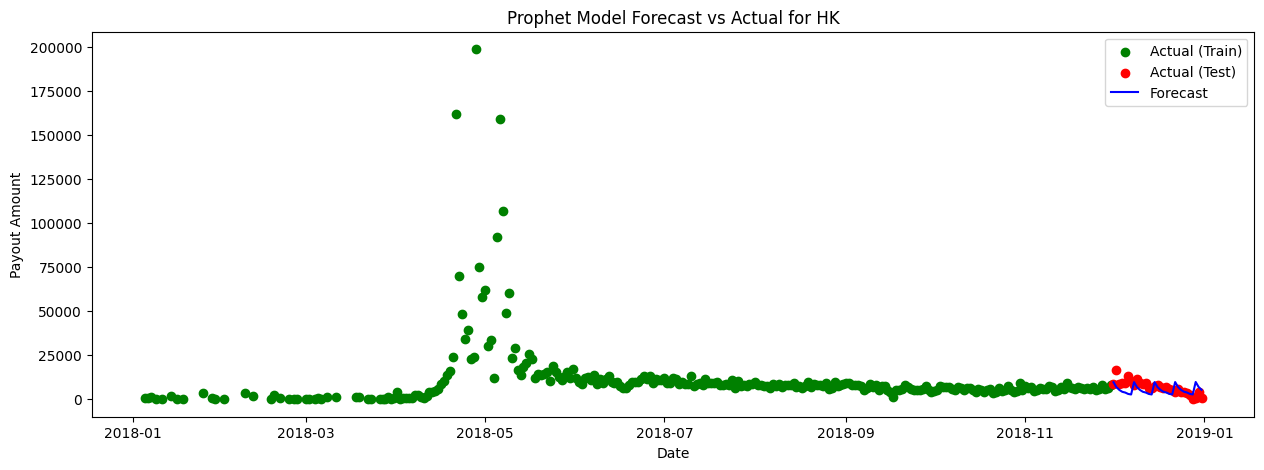

19:40:16 - cmdstanpy - INFO - Chain [1] start processing
19:40:16 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 8578.242191485204
MAE: 6018.777962375385
MAPE: 553.7940607952775
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 146789.46856193923


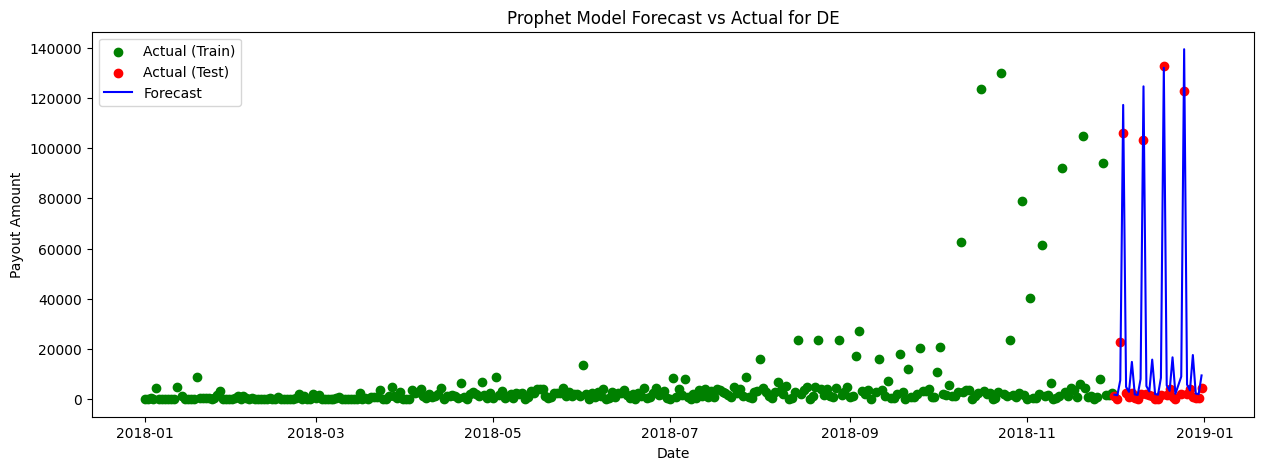

19:40:17 - cmdstanpy - INFO - Chain [1] start processing
19:40:17 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 10321.237872583162
MAE: 8337.397715470956
MAPE: 265.6366624584986
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 76961.2433176439


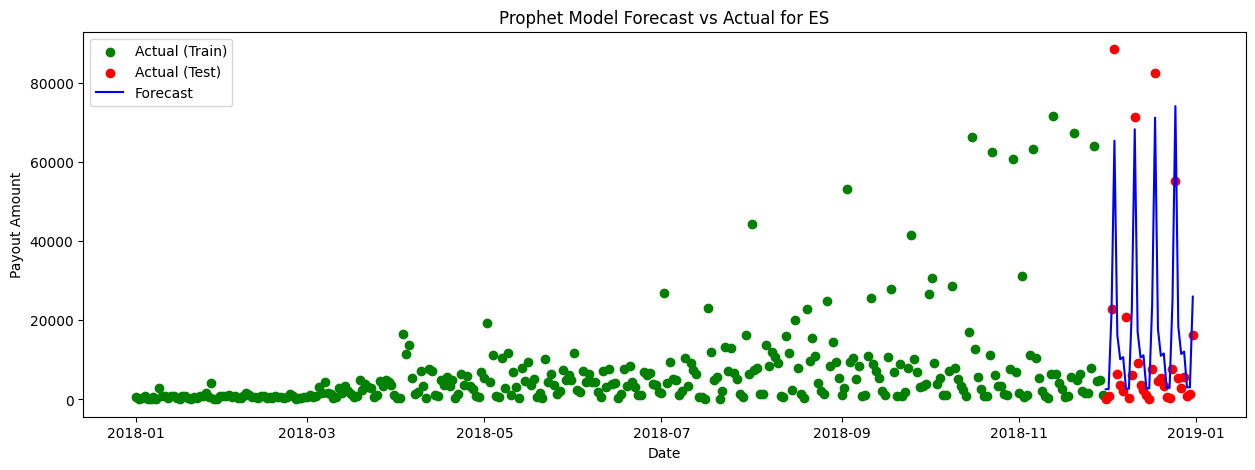

In [27]:
model_and_plot_updated(df_grouped, 'FR')
model_and_plot_updated(df_grouped, 'HK')
model_and_plot_updated(df_grouped, 'DE')
model_and_plot_updated(df_grouped, 'ES')

<b>we are seeing the test and forecast cosely to see the trends better


In [28]:
def test_and_plot_updated(df_grouped, country_name):
    # Prepare the data
    df_grouped['date_d'] = pd.to_datetime(df_grouped['date_d'])
    df_country = df_grouped[df_grouped['country'] == country_name][['date_d', 'amount']].rename(columns={'date_d': 'ds', 'amount': 'y'})
    df_train = df_country[df_country['ds'] < '2018-12-01']
    df_test = df_country[(df_country['ds'] >= '2018-12-01') & (df_country['ds'] < '2019-01-01')]

    # Train the model
    model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
    # model=Prophet()
    model.fit(df_train)

    # Make predictions
    df_test_forecast = model.predict(df_test[['ds']])
    df_test_forecast = df_test_forecast.sort_values('ds')
    df_test = df_test.sort_values('ds').reset_index()

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(df_test['y'], df_test_forecast['yhat']))
    mae = mean_absolute_error(df_test['y'], df_test_forecast['yhat'])
    mape = np.mean(np.abs((df_test['y'] - df_test_forecast['yhat']) / df_test['y'])) * 100

    # Print performance metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"Model Components: {model.component_modes}")

    # Forecast for a future date
    future = pd.DataFrame(['2019-01-01'], columns=['ds'])
    future['ds'] = pd.to_datetime(future['ds'])
    forecast = model.predict(future)
    print(f"Forecast for January 1, 2019: {forecast['yhat'].iloc[0]}")

    # Plotting the results
    fig, ax = plt.subplots(figsize=(15, 5))
    # ax.scatter(df_train['ds'], df_train['y'], color='g', label='Actual (Train)')
    ax.scatter(df_test['ds'], df_test['y'], color='r', label='Actual (Test)')
    ax.plot(df_test_forecast['ds'], df_test_forecast['yhat'], color='b', label='Forecast')

    # Set labels and legend
    ax.set_title(f'Prophet Model Forecast vs Actual for {country_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Payout Amount')
    ax.legend()

    # Show the plot
    plt.show()

19:40:17 - cmdstanpy - INFO - Chain [1] start processing
19:40:17 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 46485.197537384316
MAE: 37930.248112843656
MAPE: 102.35675072850015
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 132209.94405359795


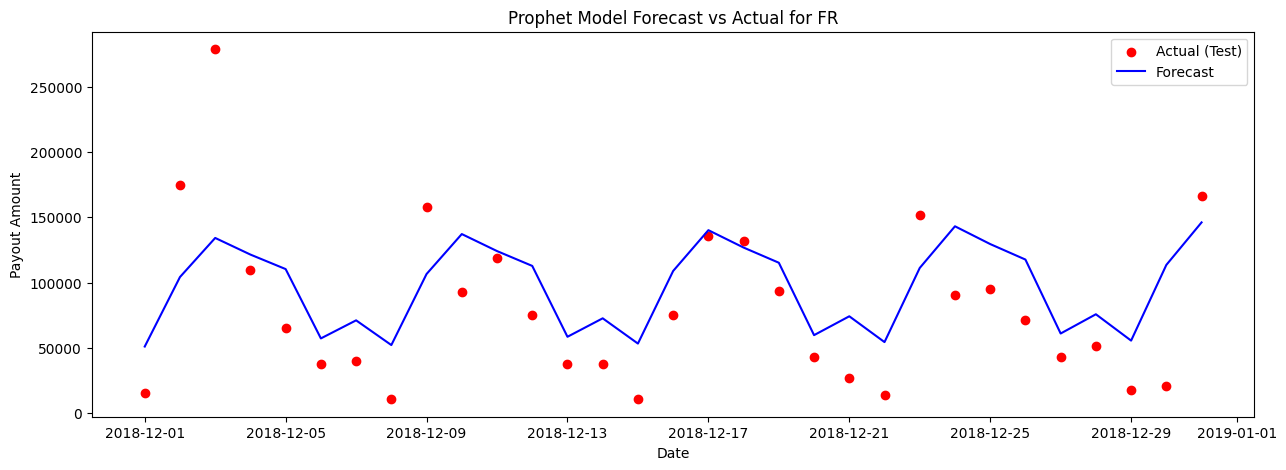

19:40:18 - cmdstanpy - INFO - Chain [1] start processing
19:40:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 4505.758845035771
MAE: 3648.917044740921
MAPE: 177.52246424605255
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 4270.579956082828


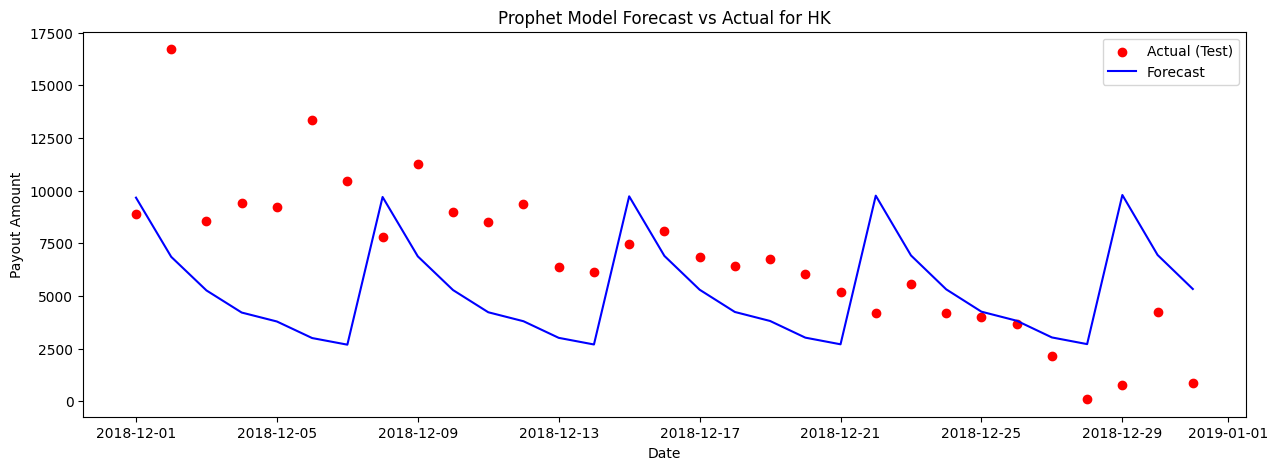

19:40:18 - cmdstanpy - INFO - Chain [1] start processing
19:40:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 8578.242191485204
MAE: 6018.777962375385
MAPE: 553.7940607952775
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 146789.46856193923


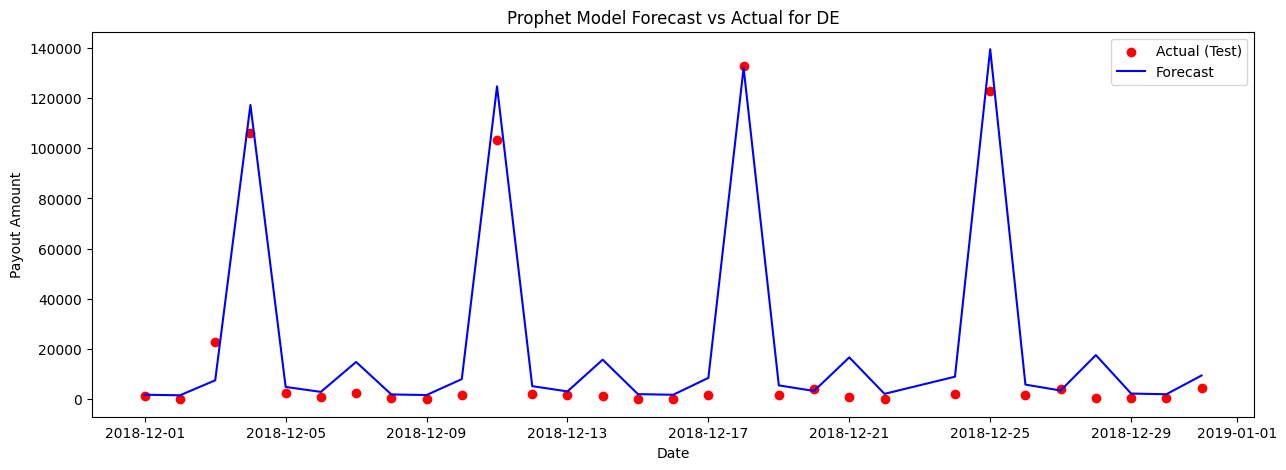

19:40:19 - cmdstanpy - INFO - Chain [1] start processing
19:40:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 10321.237872583162
MAE: 8337.397715470956
MAPE: 265.6366624584986
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 76961.2433176439


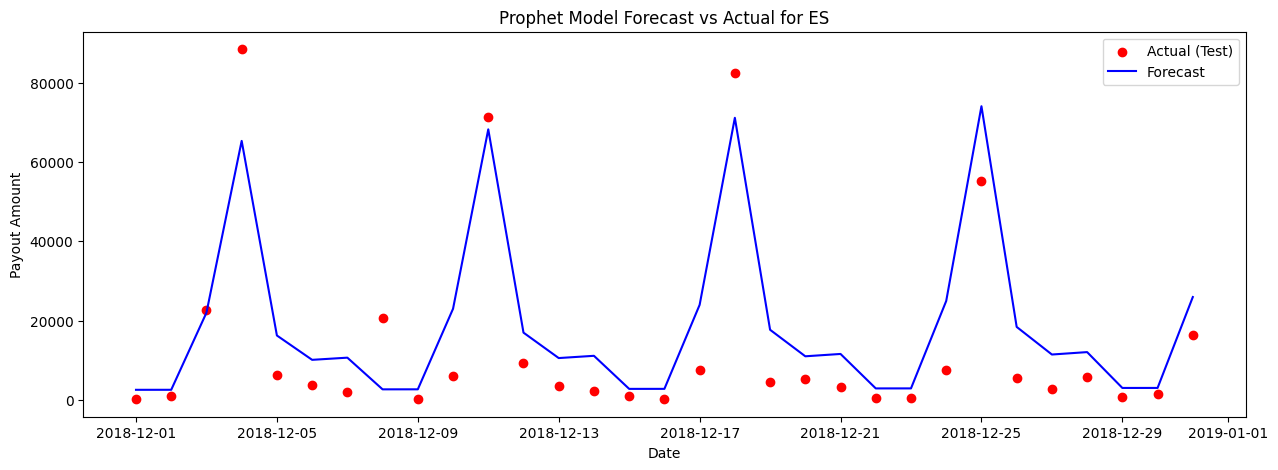

In [29]:
test_and_plot_updated(df_grouped, 'FR')
test_and_plot_updated(df_grouped, 'HK')
test_and_plot_updated(df_grouped, 'DE')
test_and_plot_updated(df_grouped, 'ES')

- For FR the training data is kind of dispersed post Q1'18. As we can see the test data is fairly dispersed and our forecast gives a fair dispersion, so I feel the forecast give a conservative estimate
- For DE and ES, the spikes and low values are fairly captured so i think the forecast looks Fine 
- For HK, we will try to add some changepoint scale which on increasing will make the trend more flexible

In [30]:
def HK_outlier_updated(df_grouped, country_name):
    # Prepare the data
    df_grouped['date_d'] = pd.to_datetime(df_grouped['date_d'])
    df_country = df_grouped[df_grouped['country'] == country_name][['date_d', 'amount']].rename(columns={'date_d': 'ds', 'amount': 'y'})
    df_train = df_country[(df_country['ds'] < '2018-12-01') ] # & (df_country['y'] < 100000) 
    df_test = df_country[(df_country['ds'] >= '2018-12-01') & (df_country['ds'] < '2019-01-01')]

    # Train the model
    model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative',changepoint_prior_scale=0.06)
    # model=Prophet()
    # model.add_changepoint('2018-04-26')
    model.fit(df_train)

    # Make predictions
    df_test_forecast = model.predict(df_test[['ds']])
    df_test_forecast = df_test_forecast.sort_values('ds')
    df_test = df_test.sort_values('ds').reset_index()

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(df_test['y'], df_test_forecast['yhat']))
    mae = mean_absolute_error(df_test['y'], df_test_forecast['yhat'])
    mape = np.mean(np.abs((df_test['y'] - df_test_forecast['yhat']) / df_test['y'])) * 100

    # Print performance metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"Model Components: {model.component_modes}")

    # Forecast for a future date
    future = pd.DataFrame(['2019-01-01'], columns=['ds'])
    future['ds'] = pd.to_datetime(future['ds'])
    forecast = model.predict(future)
    print(f"Forecast for January 1, 2019: {forecast['yhat'].iloc[0]}")

    # Plotting the results
    fig, ax = plt.subplots(figsize=(15, 5))
    # ax.scatter(df_train['ds'], df_train['y'], color='g', label='Actual (Train)')
    ax.scatter(df_test['ds'], df_test['y'], color='r', label='Actual (Test)')
    ax.plot(df_test_forecast['ds'], df_test_forecast['yhat'], color='b', label='Forecast')

    # Set labels and legend
    ax.set_title(f'Prophet Model Forecast vs Actual for {country_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Payout Amount')
    ax.legend()

    # Show the plot
    plt.show()

19:40:19 - cmdstanpy - INFO - Chain [1] start processing
19:40:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 4538.718939159079
MAE: 3643.490541187596
MAPE: 165.73385036400526
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 3945.106422322626


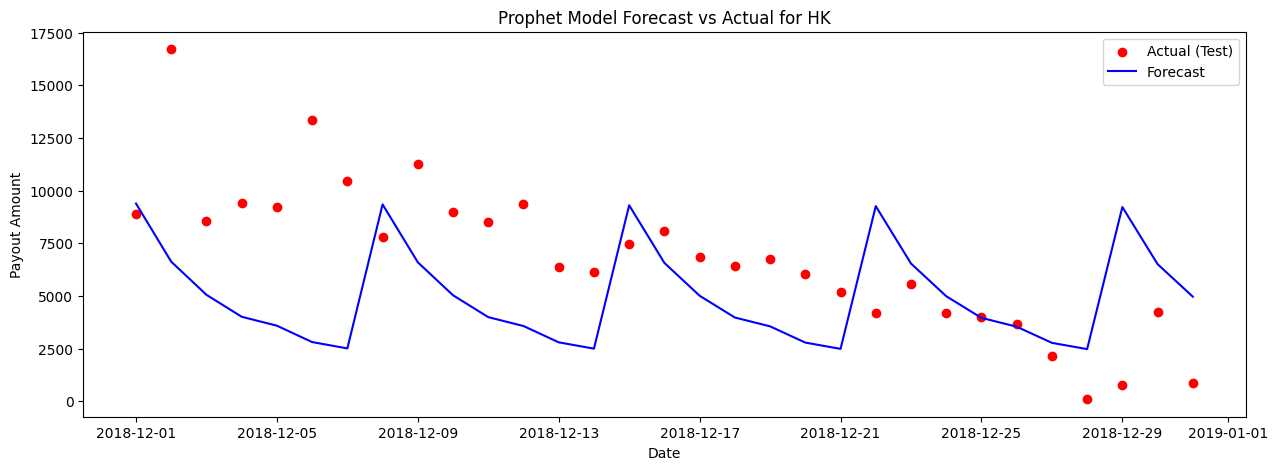

In [31]:
HK_outlier_updated(df_grouped, 'HK')

<b> Updating HK values in summary_results

In [32]:
summary_results.loc[summary_results['Country'] == 'HK', 'MAPE'] = 165.73385036400526
summary_results.loc[summary_results['Country'] == 'HK', 'Forecast for January 1, 2019'] = 3945.106422322626 

In [33]:
summary_results

,Country,MAPE,"Forecast for January 1, 2019",Data Points in Training
0,US,21.294737,4.005293e+06,334.0
1,GB,38.834610,3.644539e+05,334.0
2,FR,102.356751,1.322099e+05,334.0
3,HK,165.733850,3.945106e+03,281.0
4,CA,37.849857,4.301945e+04,334.0
5,DE,553.794061,1.467895e+05,332.0
6,AU,31.218548,7.399008e+04,334.0
7,ES,265.636662,7.696124e+04,334.0
8,FI,125.647245,4.295879e+03,222.0
9,NZ,221.702546,1.354697e+04,256.0


<b>5)checking for anomalies for rest of the countries and comment on if it's fine 

19:40:20 - cmdstanpy - INFO - Chain [1] start processing
19:40:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 23146.962323597534
MAE: 16998.08727417396
MAPE: 31.218548072724367
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 73990.07664331913


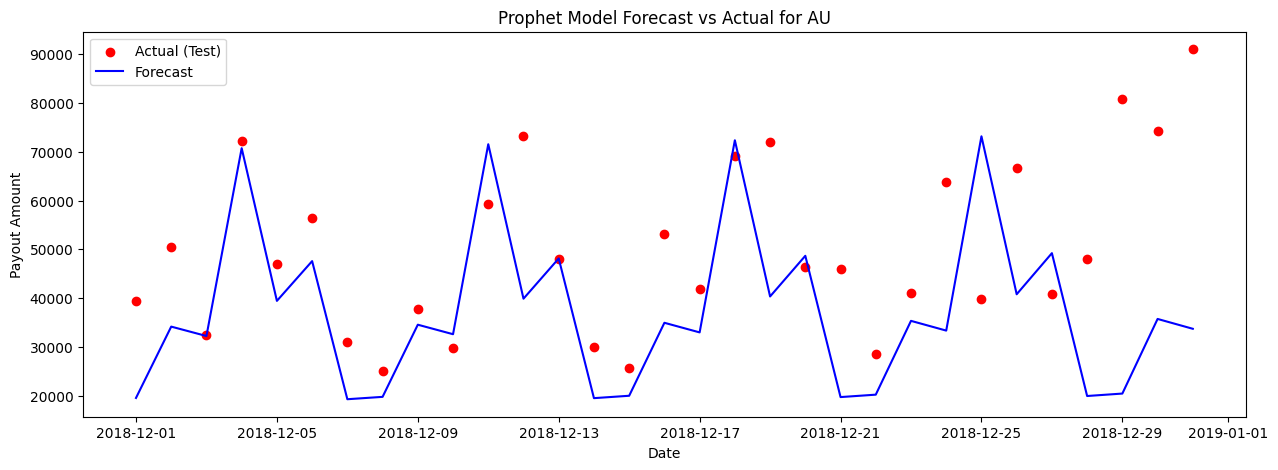

19:40:20 - cmdstanpy - INFO - Chain [1] start processing
19:40:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 10321.237872583162
MAE: 8337.397715470956
MAPE: 265.6366624584986
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 76961.2433176439


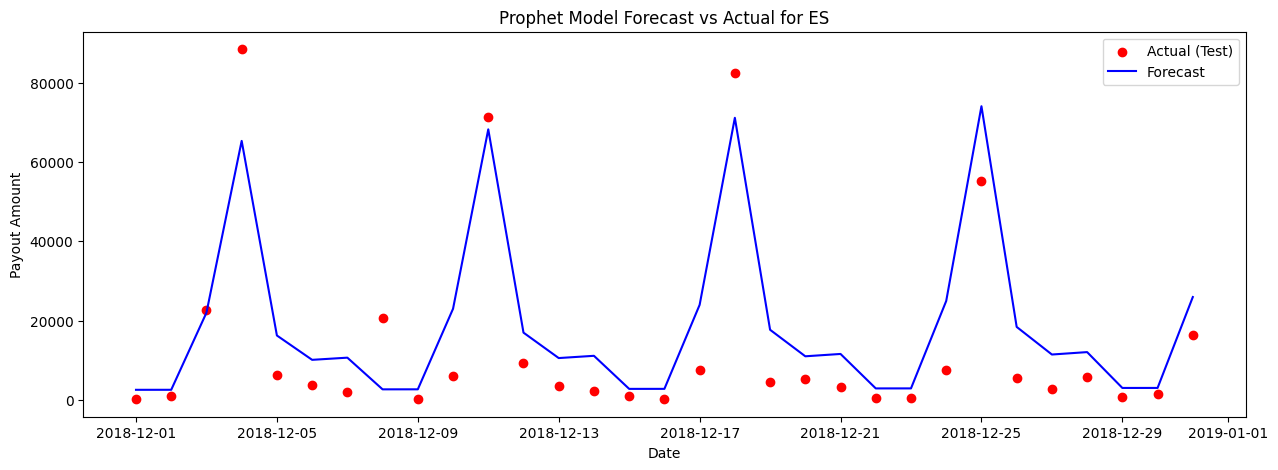

19:40:21 - cmdstanpy - INFO - Chain [1] start processing
19:40:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 12695.949190928335
MAE: 4581.795217705571
MAPE: 125.64724476003795
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 4295.878824057432


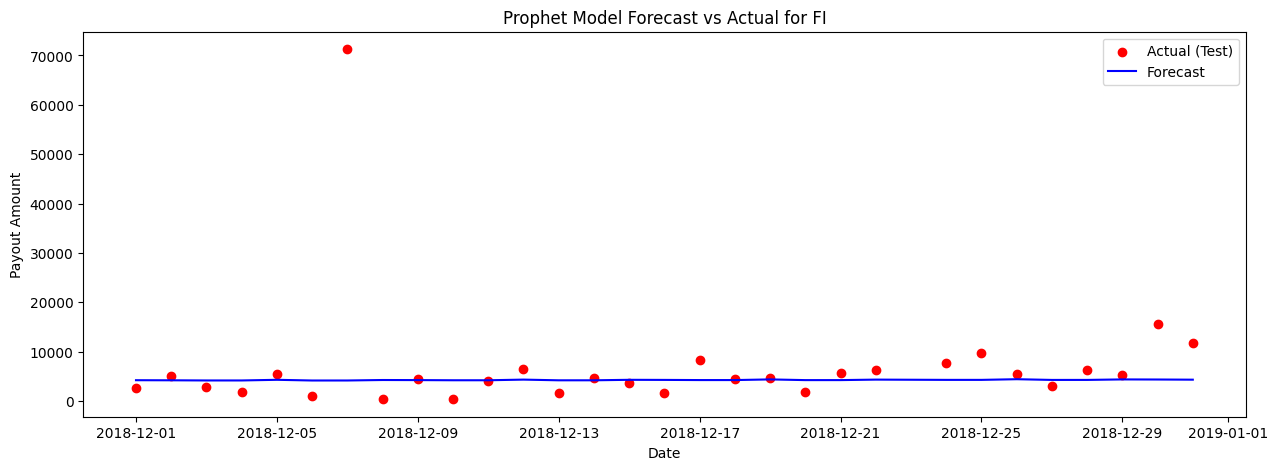

19:40:21 - cmdstanpy - INFO - Chain [1] start processing
19:40:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 13384.397115722313
MAE: 7665.95873865877
MAPE: 221.70254570550628
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 13546.967775221883


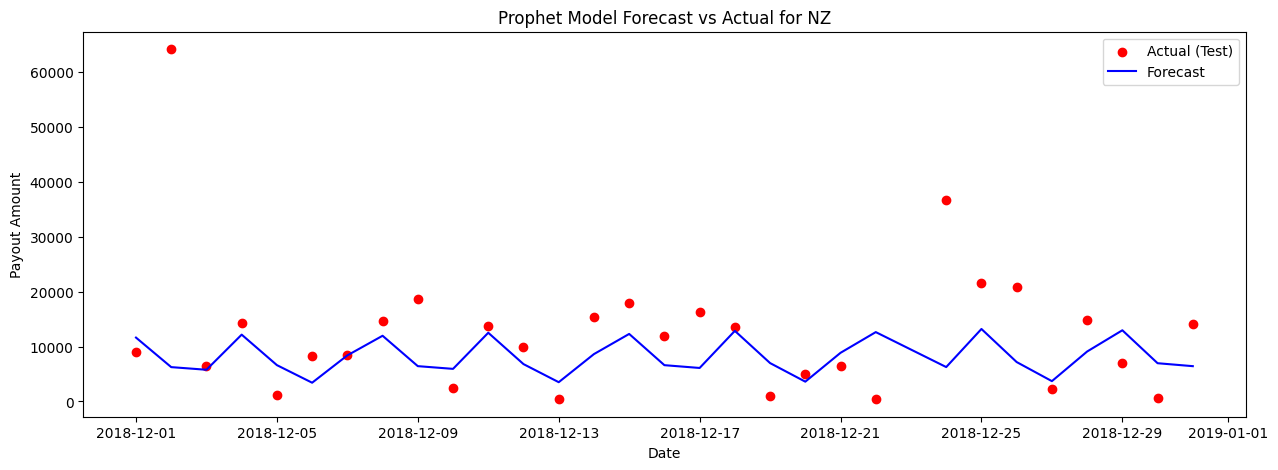

In [34]:
test_and_plot_updated(df_grouped, 'AU')
test_and_plot_updated(df_grouped, 'ES')
test_and_plot_updated(df_grouped, 'FI')
test_and_plot_updated(df_grouped, 'NZ')
# Plots look fine 

MX AND LU have lest training data so lets give more training data and use less testing, giving data till dec 26, also removed outliers for MX

In [35]:
def model_and_plot_updated_MX_LU(df_grouped, country_name):
    # Prepare the data
    df_grouped['date_d'] = pd.to_datetime(df_grouped['date_d'])
    df_country = df_grouped[df_grouped['country'] == country_name][['date_d', 'amount']].rename(columns={'date_d': 'ds', 'amount': 'y'})
    df_train = df_country[(df_country['ds'] < '2018-12-22') & (df_country['y'] < 50000)]
    df_test = df_country[(df_country['ds'] >= '2018-12-20') & (df_country['ds'] < '2019-01-01')]

    # Train the model
    model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
    # model=Prophet()
    model.fit(df_train)

    # Make predictions
    df_test_forecast = model.predict(df_test[['ds']])
    df_test_forecast = df_test_forecast.sort_values('ds')
    df_test = df_test.sort_values('ds').reset_index()

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(df_test['y'], df_test_forecast['yhat']))
    mae = mean_absolute_error(df_test['y'], df_test_forecast['yhat'])
    mape = np.mean(np.abs((df_test['y'] - df_test_forecast['yhat']) / df_test['y'])) * 100

    # Print performance metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"Model Components: {model.component_modes}")

    # Forecast for a future date
    future = pd.DataFrame(['2019-01-01'], columns=['ds'])
    future['ds'] = pd.to_datetime(future['ds'])
    forecast = model.predict(future)
    print(f"Forecast for January 1, 2019: {forecast['yhat'].iloc[0]}")

    # Plotting the results
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df_train['ds'], df_train['y'], color='g', label='Actual (Train)')
    ax.scatter(df_test['ds'], df_test['y'], color='r', label='Actual (Test)')
    ax.plot(df_test_forecast['ds'], df_test_forecast['yhat'], color='b', label='Forecast')

    # Set labels and legend
    ax.set_title(f'Prophet Model Forecast vs Actual for {country_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Payout Amount')
    ax.legend()

    # Show the plot
    plt.show()

19:40:22 - cmdstanpy - INFO - Chain [1] start processing
19:40:22 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 7563.311961095217
MAE: 4113.834627193545
MAPE: 82.86034717147979
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 13.807611619763685


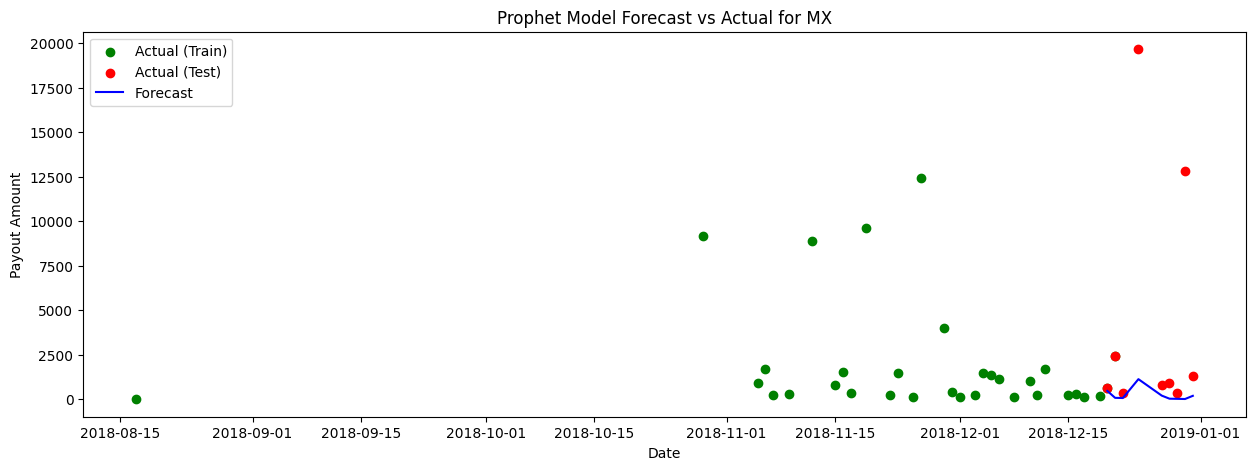

19:40:22 - cmdstanpy - INFO - Chain [1] start processing
19:40:22 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 2044.6640722549757
MAE: 1829.2094898972177
MAPE: 4841.53426595827
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 1422.5476599381707


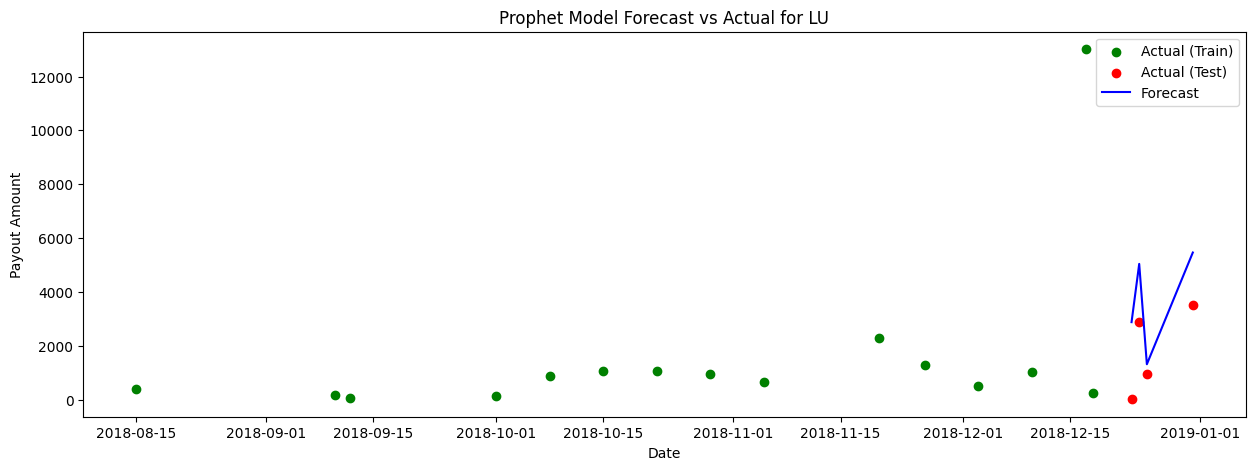

In [36]:
model_and_plot_updated_MX_LU(df_grouped,'MX')
model_and_plot_updated_MX_LU(df_grouped,'LU')

In [37]:
# updating summary for MX and LU
summary_results.loc[summary_results['Country'] == 'MX', 'MAPE'] = 82.86034717147979
summary_results.loc[summary_results['Country'] == 'MX', 'Forecast for January 1, 2019'] = 13.807611619763685

summary_results.loc[summary_results['Country'] == 'LU', 'MAPE'] = 4841.53426595827
summary_results.loc[summary_results['Country'] == 'LU', 'Forecast for January 1, 2019'] = 1422.5476599381707

19:40:23 - cmdstanpy - INFO - Chain [1] start processing
19:40:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 2567.1585311765216
MAE: 1928.2576282507553
MAPE: 961.9148198498468
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 35470.67584178032


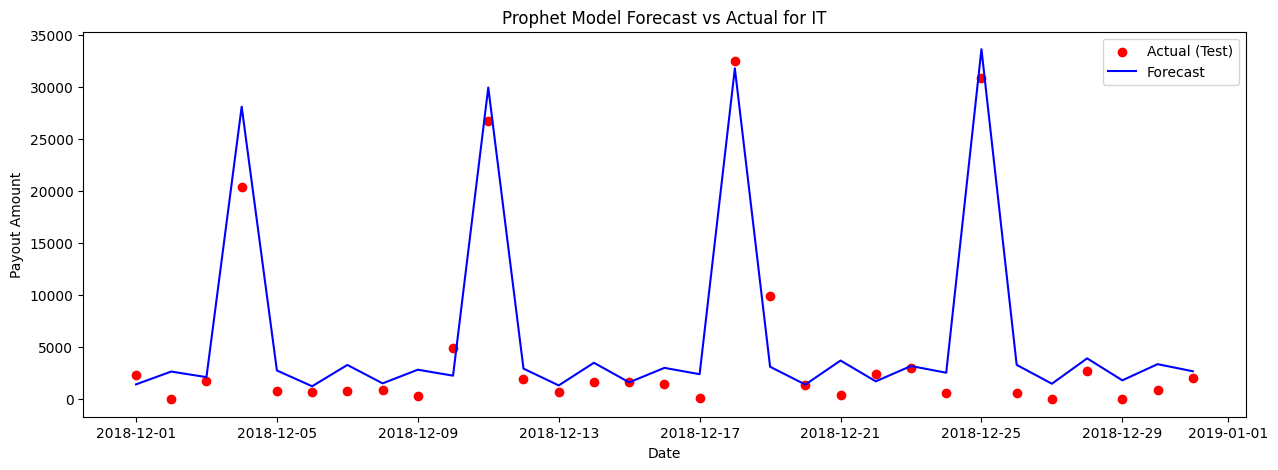

19:40:23 - cmdstanpy - INFO - Chain [1] start processing
19:40:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 2407.2574755062296
MAE: 2058.451111881857
MAPE: 326.40629762092516
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 17488.39806706477


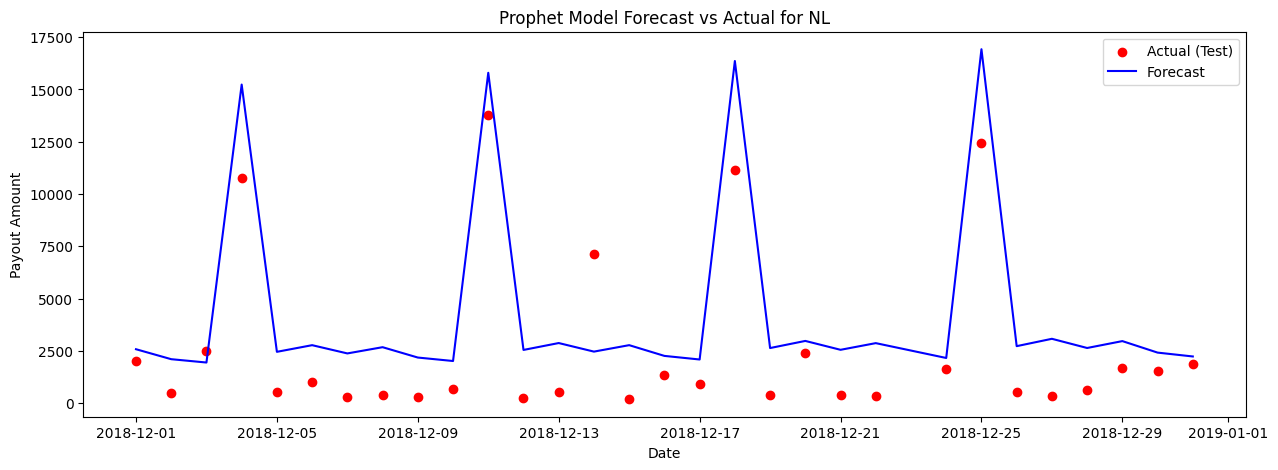

19:40:24 - cmdstanpy - INFO - Chain [1] start processing
19:40:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 3282.201255549176
MAE: 2354.0212732595683
MAPE: 493.0508652631727
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 5872.012329022345


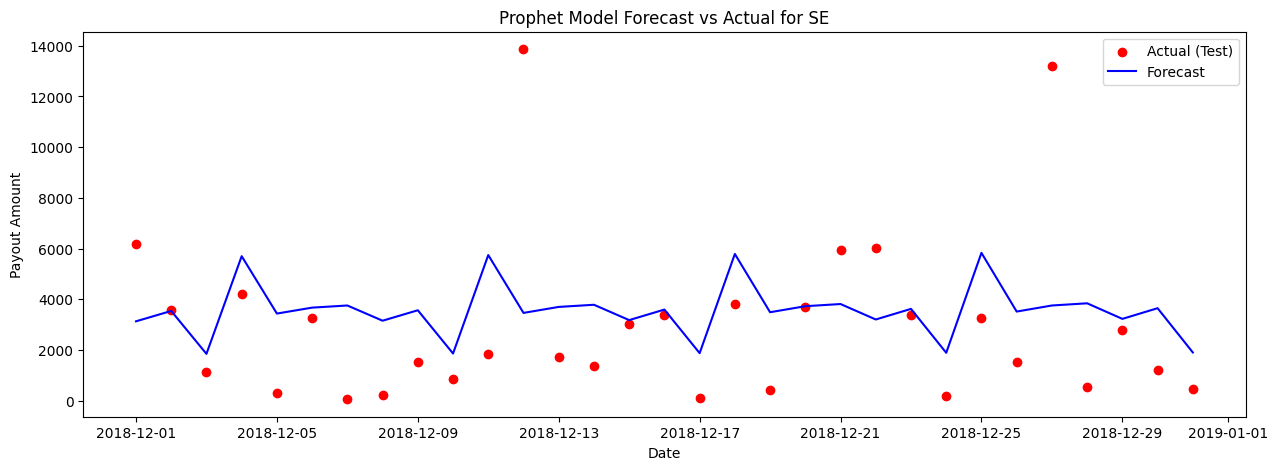

19:40:24 - cmdstanpy - INFO - Chain [1] start processing
19:40:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1788.9106471615546
MAE: 1584.6519532921966
MAPE: 429.8955048512042
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 12162.168658248356


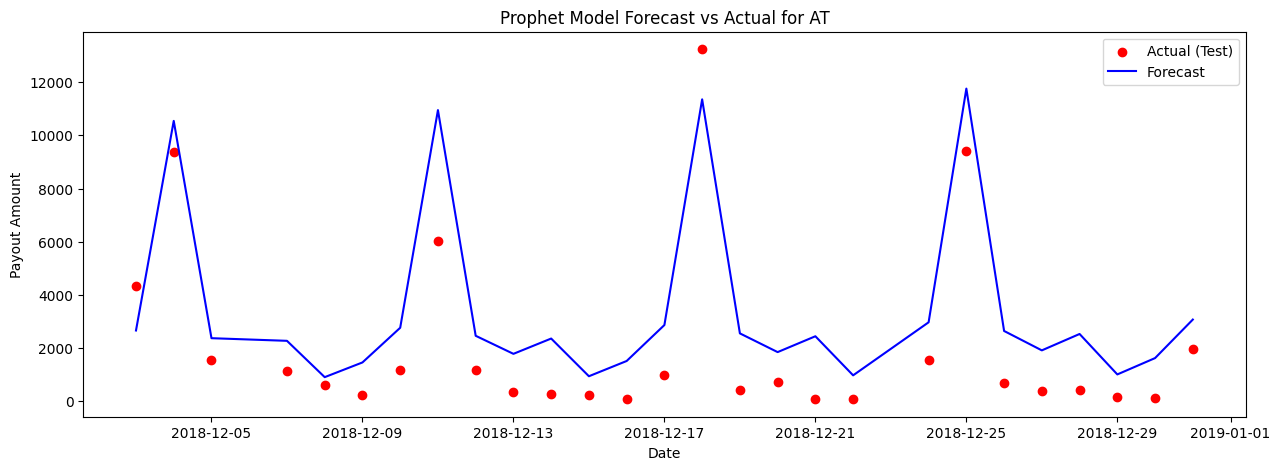

In [38]:
test_and_plot_updated(df_grouped, 'IT')
test_and_plot_updated(df_grouped, 'NL')
test_and_plot_updated(df_grouped, 'SE')
test_and_plot_updated(df_grouped, 'AT')
# Plots look fine 

19:40:25 - cmdstanpy - INFO - Chain [1] start processing
19:40:25 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1525.8278152490827
MAE: 905.7736601779754
MAPE: 449.45718892892364
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 15478.253952011448


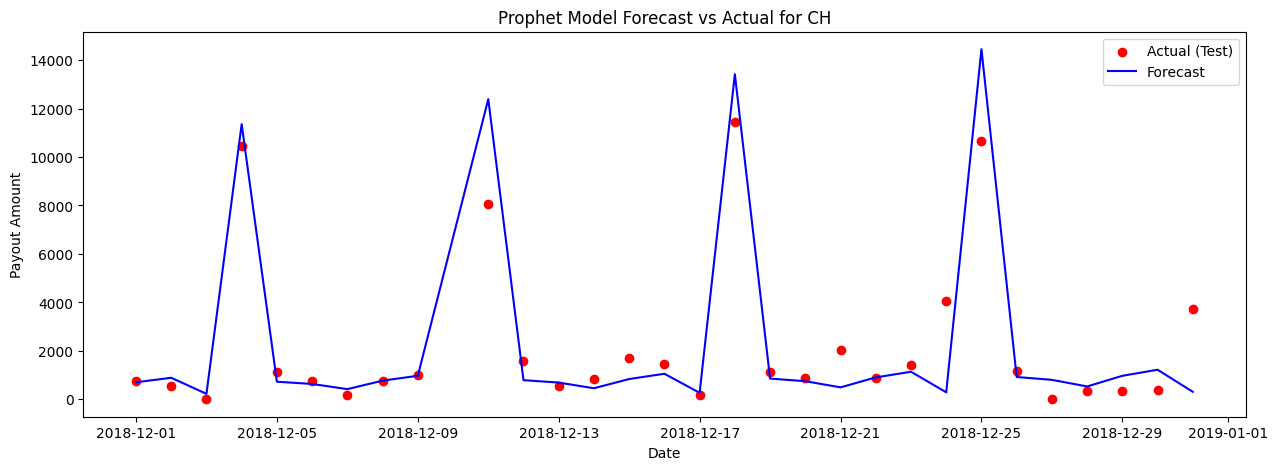

19:40:25 - cmdstanpy - INFO - Chain [1] start processing
19:40:25 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 984.8995331891743
MAE: 709.2199918105993
MAPE: 115.6927886592075
Model Components: {'additive': ['additive_terms', 'extra_regressors_additive'], 'multiplicative': ['weekly', 'daily', 'multiplicative_terms', 'extra_regressors_multiplicative', 'holidays']}
Forecast for January 1, 2019: 1590.594045182535


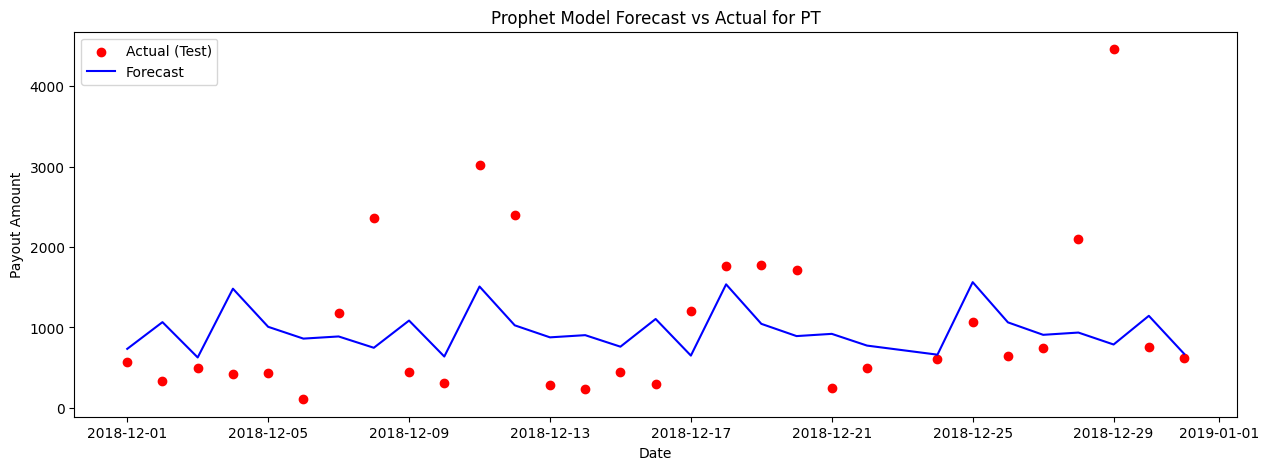

In [39]:
test_and_plot_updated(df_grouped, 'CH')
test_and_plot_updated(df_grouped, 'PT')
#looks fine apart from few outliers

# Final summary for Q1 
<b> 6)wrap up 1st Qn

In [40]:
summary_results[['Country', 'Forecast for January 1, 2019']]

,Country,"Forecast for January 1, 2019"
0,US,4.005293e+06
1,GB,3.644539e+05
2,FR,1.322099e+05
3,HK,3.945106e+03
4,CA,4.301945e+04
5,DE,1.467895e+05
6,AU,7.399008e+04
7,ES,7.696124e+04
8,FI,4.295879e+03
9,NZ,1.354697e+04


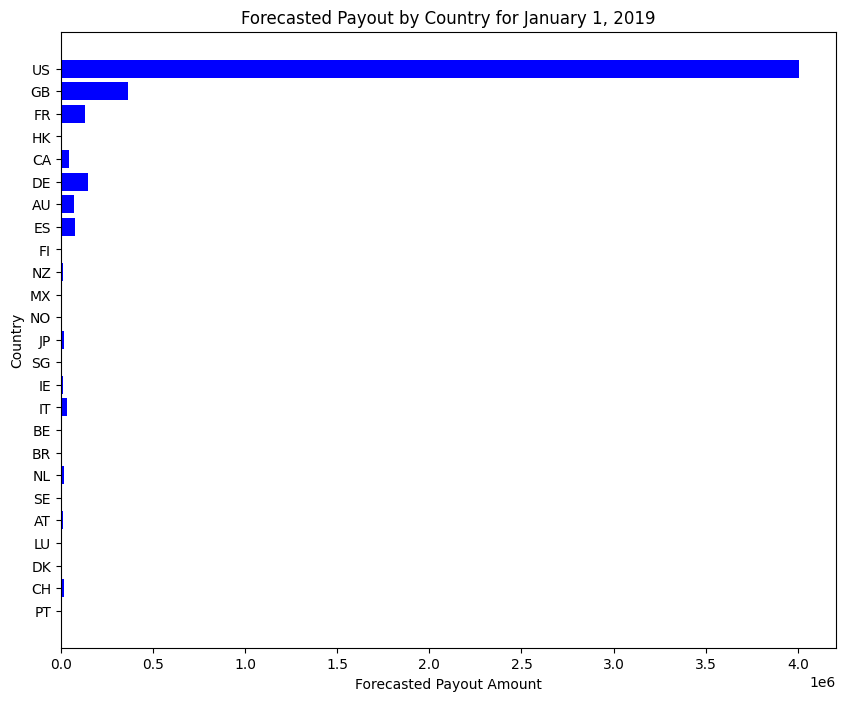

In [41]:
plt.figure(figsize=(10, 8))
plt.barh(summary_results['Country'], summary_results['Forecast for January 1, 2019'], color='blue')
plt.xlabel('Forecasted Payout Amount')
plt.ylabel('Country')
plt.title('Forecasted Payout by Country for January 1, 2019')
plt.gca().invert_yaxis()  # To display the highest value at the top
plt.show()

# Q2) Assume that one year from the end of the dataset, we will have 15 platforms from the Education industry, 5 from Hotels, Restaurants & Leisure and 40 from Food & Beverage. How much total payout volume do you expect to see on a typical day in 2019, from these three industries?

<b>1)checking Missing values in payouts and country tables

<b>Steps in the Analysis
- payout volume for a platform, we want to see how much payouts is done by an industry so we will have to tag platform id to the industry 
- 1)checking Missing values in payouts and country tables
- 2)Checking whether all recipient_ids have a country associated with it(if it's significant then it will need special treatment)
- 3)checking mix of payouts by industry
- 4)checking trends and fitting prophet model for the major industries and given filters, we change amount to $ here from cents
- 5)wrap up 2nd Qn

In [42]:
industries.isnull().sum()

merchant_id    0
industry       1
dtype: int64

In [43]:
industries[industries.isnull().any(axis=1)]

,merchant_id,industry
70951,id_b877e047c48a77aa883cd3bbba95ce58,NaN


In [44]:
#seeing the payout volume for this merchant_id, it's 0 so chill
payouts[payouts['recipient_id']=='id_b877e047c48a77aa883cd3bbba95ce58']['amount'].sum()

0.0

<b>2)Checking whether all platform_id s have a country associated with it(if it's significant then it will need special treatment)

In [45]:
distinct_recipients_count = payouts['platform_id'].nunique()
distinct_merchants_count = industries['merchant_id'].nunique()
matching_merchants_count = payouts[payouts['platform_id'].isin(industries['merchant_id'])]['recipient_id'].nunique()
non_matching_merchants = payouts[~payouts['platform_id'].isin(industries['merchant_id'])]
non_matching_merchants_count = non_matching_merchants['platform_id'].nunique()
non_matching_merchants_amount = non_matching_merchants['amount'].sum() / 100  

print(f"Distinct platforms count: {distinct_recipients_count}")
print(f"Distinct merchants count: {distinct_merchants_count}")
print(f"Matching merchants with an industry code count: {matching_merchants_count}")
print(f"Merchants without an industry code count: {non_matching_merchants_count}")
print(f"Total payout for merchants without an industry code count: {non_matching_merchants_amount:,.2f} cents")
print(f"Total payout for merchants without an industry code count as % of total: {non_matching_merchants_amount*100.00/payouts['amount'].sum():,.5f}%") 

Distinct platforms count: 463
Distinct merchants count: 112309
Matching merchants with an industry code count: 111929
Merchants without an industry code count: 46
Total payout for merchants without an industry code count: 19,809.39 cents
Total payout for merchants without an industry code count as % of total: 0.00001%


<b>3)checking mix of payouts by industry

In [46]:
df_merge = pd.merge(payouts, industries, left_on='platform_id', right_on='merchant_id')
total_payouts_by_industry = df_merge.groupby('industry')['amount'].sum()
total_payouts = total_payouts_by_industry.sum()
percentage_mix = (total_payouts_by_industry / total_payouts) * 100
percentage_mix.sort_values(ascending=False)

industry
Tickets: concerts,sports,movies,conventions          4.728851e+01
Professional Services (non-medical)                  1.597314e+01
Non-profit                                           1.247816e+01
Other Software & Content                             1.149781e+01
Food & Beverage                                      3.136151e+00
Travel & Hospitality                                 2.576206e+00
Other Services                                       2.389887e+00
Education                                            2.193573e+00
Healthcare                                           1.209312e+00
Content                                              8.603359e-01
Retail Fashion                                       1.382931e-01
Direct Services: classes,memberships,appointments    1.166705e-01
Other Retail                                         9.053227e-02
Financial Services                                   4.917216e-02
Real Estate                                          2.241714e-03
i

- Education
- hotels, restaurants & leisure 
- Food & Beverage, let's see the number of merchants and payouts volume 

In [47]:
industry_stats = df_merge.groupby('industry').agg({
    'platform_id': pd.Series.nunique,  # Number of unique merchants
    'amount': 'sum'  # Total payout volume
}).rename(columns={
    'platform_id': 'number_of_merchants',
    'amount': 'total_payout_volume'
})
interested_industries = ['Education', 'hotels, restaurants & leisure', 'Food & Beverage','Travel & Hospitality']

# Filter the aggregated data for the interested industries.
# Travel & Hospitality used as a proxy for hotels, restaurants & leisure  
industry_stats = industry_stats.loc[industry_stats.index.isin(interested_industries)]

print(industry_stats)

                               number_of_merchants  total_payout_volume
industry                                                               
Education                                        5         2.950257e+09
Food & Beverage                                 15         4.217981e+09
Travel & Hospitality                            12         3.464881e+09
hotels, restaurants & leisure                    1         9.400000e+01


We have to now predict the total payout volume on a typical day assuming Education will have 15 , hotels, restaurants & leisure  will have 5 and Food & Beverage will have 40 platforms at the end of 2019. 

<b>4)checking trends and fitting prophet model for the major industries and given filters, we change amount to $ here from cents

In [48]:
#preparing data by summing up the amt by date
df_merge['date_d'] = pd.to_datetime(df_fnl['date']).dt.date
df_prop = df_merge.groupby(['industry', 'date_d'])['amount'].sum().sort_values(ascending=False).reset_index()
df_prop['amount'] = df_prop['amount']/100

In [49]:
#both education and food ahve 365 day data
df_prop[df_prop['industry'] == 'Education']

,industry,date_d,amount
1223,Education,2018-12-26,263087.56
1266,Education,2018-12-18,245044.95
1285,Education,2018-09-11,238679.83
1287,Education,2018-11-20,237774.44
1307,Education,2018-10-23,230172.43
...,...,...,...
3642,Education,2018-02-24,12165.34
3659,Education,2018-01-12,11611.11
3680,Education,2018-04-14,10945.24
3690,Education,2018-02-17,10559.33


In [50]:
df_prop[df_prop['industry'] == 'Food & Beverage']

,industry,date_d,amount
1096,Food & Beverage,2018-12-04,321666.13
1203,Food & Beverage,2018-09-05,268809.78
1207,Food & Beverage,2018-11-14,267523.91
1213,Food & Beverage,2018-10-02,266017.86
1228,Food & Beverage,2018-11-20,262332.88
...,...,...,...
3106,Food & Beverage,2018-02-17,34985.17
3118,Food & Beverage,2018-02-03,34565.82
3119,Food & Beverage,2018-01-20,34555.16
3154,Food & Beverage,2018-02-24,33181.21


In [51]:
#hotels only have a row so not used for prediction using prophet
df_merge[df_merge['industry'] == 'hotels, restaurants & leisure']

,date,platform_id,recipient_id,count,amount,merchant_id,industry,date_d
1502647,2018-08-02 00:00:00+00:00,id_8e91078fc89115f2333bd058e75a4b59,id_a82c7f841039659a2764d79f05265c36,1,94.0,id_8e91078fc89115f2333bd058e75a4b59,"hotels, restaurants & leisure",2018-09-06


In [52]:
df_prop=df_prop.rename(columns={
    'date_d': 'ds',
    'amount': 'y'
})
df_prop

,industry,ds,y
0,Other Software & Content,2018-11-22,5395553.76
1,"Tickets: concerts,sports,movies,conventions",2018-10-16,4130297.61
2,"Tickets: concerts,sports,movies,conventions",2018-10-02,4129384.50
3,Other Software & Content,2018-01-10,4097032.80
4,"Tickets: concerts,sports,movies,conventions",2018-12-04,4031280.54
...,...,...,...
4927,Real Estate,2018-11-16,0.52
4928,internet software & services,2018-02-08,0.43
4929,Real Estate,2018-07-07,0.20
4930,Real Estate,2018-12-23,0.18


In [53]:
def forecast_industry(df, industry_name):
    # Filter the data for the specified industry
    df_industry = df[df['industry'] == industry_name]
    
    # Convert date to datetime and ensure it's the correct format for Prophet
    df_industry['ds'] = pd.to_datetime(df_industry['ds'])
    
    # Split the data into training and testing sets
    df_train = df_industry[df_industry['ds'] < '2018-11-01']
    df_test = df_industry[(df_industry['ds'] >= '2018-11-01') & (df_industry['ds'] < '2019-01-01')]
    
    # Initialize and fit the Prophet model
    model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
    model.fit(df_train)
    
    # Predict on the test set
    df_test_forecast = model.predict(df_test[['ds']])
    
    df_test = df_test.sort_values('ds').reset_index()
    df_test= df_test[['ds','y']]
    df_test_forecast = df_test_forecast.sort_values('ds')
    
    # Calculate the performance metrics
    rmse = np.sqrt(mean_squared_error(df_test['y'], df_test_forecast['yhat']))
    mae = mean_absolute_error(df_test['y'], df_test_forecast['yhat'])
    mape = np.mean(np.abs((df_test['y'] - df_test_forecast['yhat']) / df_test['y'])) * 100
    
    # Forecast for January 1, 2019
    future = pd.DataFrame(['2019-01-01'], columns=['ds'])
    future['ds'] = pd.to_datetime(future['ds'])
    forecast = model.predict(future)
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    # print(f"Forecast for January 1, 2019: {forecast['yhat'].iloc[0]}")
    # Plot the forecast with the actuals
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df_test['ds'], df_test['y'], color='r', label='Actual')
    # ax.scatter(df_train['ds'], df_train['y'], color='g', label='Actual (Train)')
# Plotting the forecasted values from the Prophet model
# Assuming 'ds' is the date column in df_test_forecast and 'yhat' is the forecasted value column
    ax.plot(df_test_forecast['ds'], df_test_forecast['yhat'], color='b', label='Forecast')

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Payout Amount')
    plt.title(f'Forecast vs Actuals for {industry_name}')
    plt.show()

    
    return df_test,df_train,df_test_forecast

C:\Users\krish\AppData\Local\Temp\ipykernel_26448\758879943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_industry['ds'] = pd.to_datetime(df_industry['ds'])
19:41:02 - cmdstanpy - INFO - Chain [1] start processing
19:41:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 44169.75055271423
MAE: 37840.72484385446
MAPE: 67.40636253203061


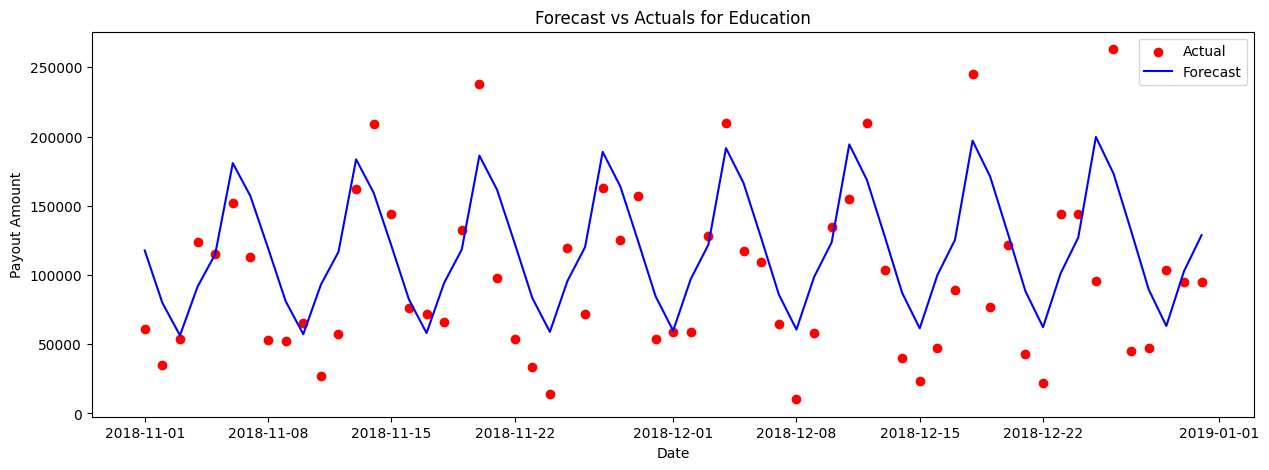

C:\Users\krish\AppData\Local\Temp\ipykernel_26448\758879943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_industry['ds'] = pd.to_datetime(df_industry['ds'])
19:41:03 - cmdstanpy - INFO - Chain [1] start processing
19:41:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 36214.97683690308
MAE: 29403.891223157967
MAPE: 28.400480674409035


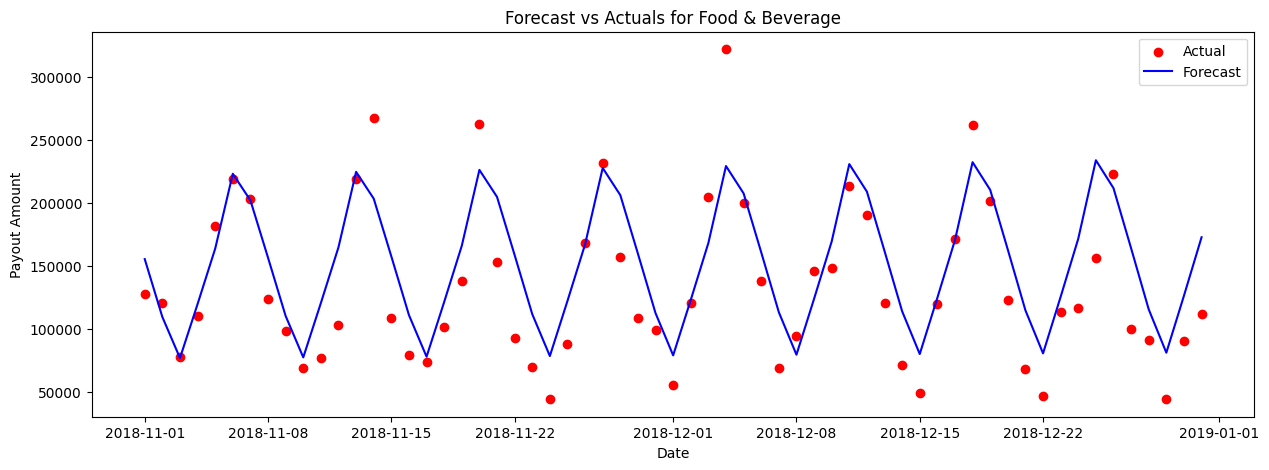

In [55]:
df_test,df_train,df_test_forecast = forecast_industry(df_prop, 'Education') 
df_test2,df_train2,df_test_forecast2 = forecast_industry(df_prop, 'Food & Beverage') 
# Travel & Hospitality 

In [56]:
# checking the sum of test and forecast for nov-dec test population 
print('Sum of payouts on Education',df_test['y'].sum(),df_test_forecast['yhat'].sum(),np.abs(df_test_forecast['yhat'].sum()-df_test['y'].sum())*100/df_test['y'].sum())

print('Sum of payouts on Food & Beverage',df_test2['y'].sum(),df_test_forecast2['yhat'].sum(),np.abs(df_test_forecast2['yhat'].sum()-df_test2['y'].sum())*100/df_test['y'].sum())

Sum of payouts on Education 6056502.9 7238619.472762245 19.518137649405638
Sum of payouts on Food & Beverage 8153269.51 9258465.96950758 18.248095935157245


The forecast looks good from mape pov/eyetest and also while summed up on test data so we will now use same parameters to train the data for whole year and predict the payouts for 2019 
- With the predicted yearly data, we will sum it up and then we will scale it by a factor of (year end merchant - year_beginning merchants)*0.5 
- then we will divide it by 365 to get the typical volume for each industry

In [57]:
#forecasting annual payouts
def forecast_annual_industry(df, industry_name):
    # Filter the data for the specified industry
    df_industry = df[df['industry'] == industry_name].copy()
    
    # Convert date to datetime and ensure it's the correct format for Prophet
    df_industry['ds'] = pd.to_datetime(df_industry['ds'])
    df_industry['y'] = df_industry['y']
    
    # Use all data up to 2019 for training
    df_train = df_industry[df_industry['ds'] < '2019-01-01']
    
    # Initialize and fit the Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
    model.fit(df_train)
    
    # Create a future DataFrame for the year 2019
    future = pd.DataFrame(pd.date_range('2019-01-01', '2019-12-31'), columns=['ds'])
    
    # Predict over the future DataFrame
    forecast = model.predict(future)
    
    # Plot the forecast
    plt.figure(figsize=(15, 5))
    plt.plot(df_train['ds'], df_train['y'], 'r.', label='Historical Data')
    plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Payout Amount')
    plt.title(f'Forecast for the Year 2019 for {industry_name}')
    plt.show()
    
    # Return the forecast DataFrame
    return forecast

19:41:09 - cmdstanpy - INFO - Chain [1] start processing
19:41:09 - cmdstanpy - INFO - Chain [1] done processing


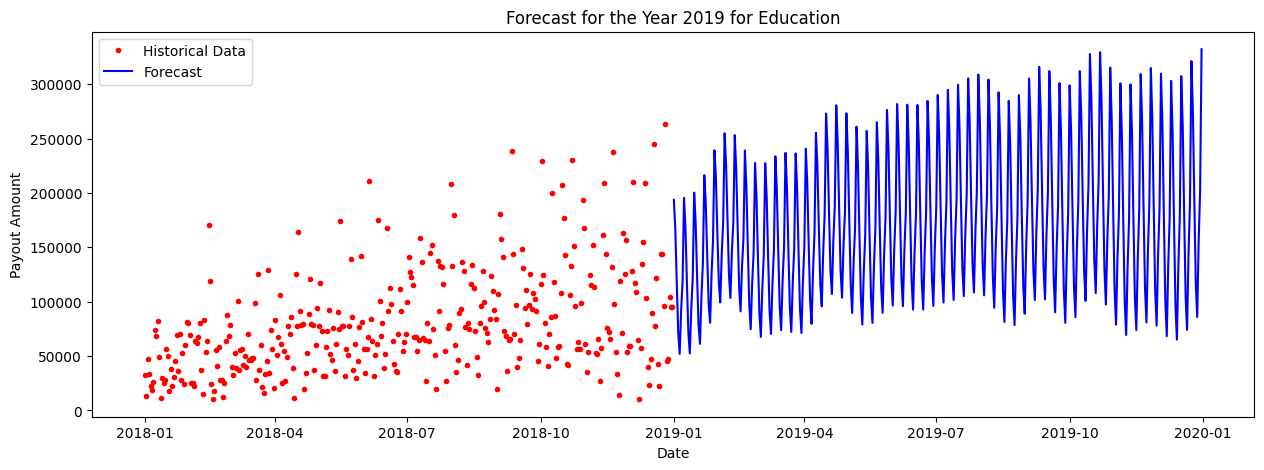

19:41:09 - cmdstanpy - INFO - Chain [1] start processing
19:41:09 - cmdstanpy - INFO - Chain [1] done processing


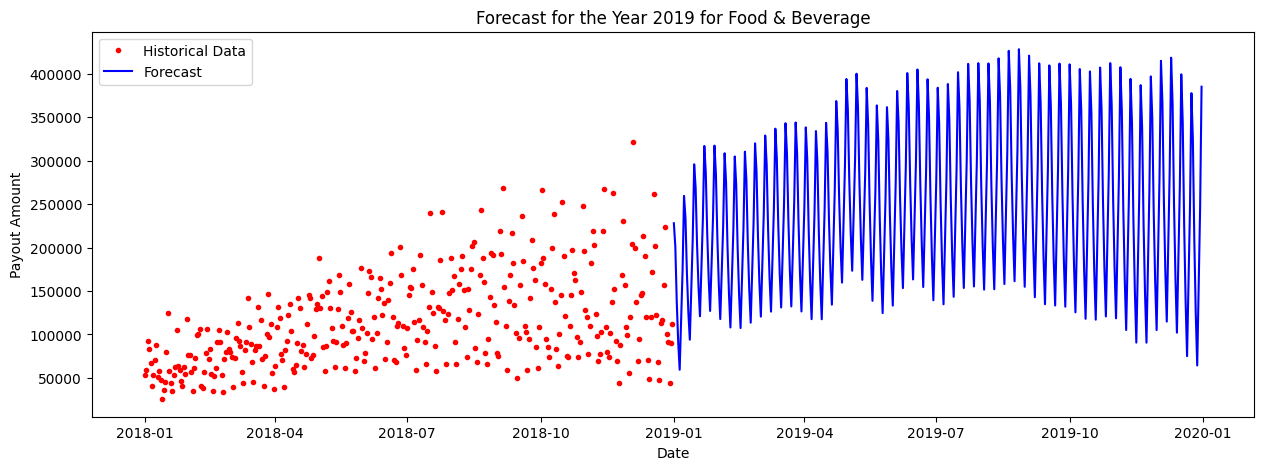

In [58]:
df_ed = forecast_annual_industry(df_prop, 'Education') 
df_FB = forecast_annual_industry(df_prop, 'Food & Beverage')

# 5) Wrapping up the payouts by industry on a typical day in 2019

- With the predicted yearly data, we will sum it up and then we will scale it by a factor of (year end merchant - year_beginning merchants)*0.5 
- then we will divide it by 365 to get the typical volume for each industry

In [59]:
#summing up for education
# final -> 15 platforms from the Education industry, 5 from Hotels, Restaurants & Leisure and 40 from Food & Beverage
# initial -> 5 platforms from the Education industry, 1 from Hotels, Restaurants & Leisure and 15 from Food & Beverage
sum_ed= df_ed['yhat'].sum()
initial_merchants_ed=5
final_merchants_ed=15
diff= final_merchants_ed-initial_merchants_ed
scaled_sum_ed=sum_ed*diff*0.5 
typical_volume_ed=scaled_sum_ed/365
typical_volume_ed

863151.2532331393

In [60]:
sum_fb= df_FB['yhat'].sum()
initial_merchants_fb=15
final_merchants_fb=40
diff= final_merchants_fb-initial_merchants_fb
scaled_sum_fb=sum_ed*diff*0.5 
typical_volume_fb=scaled_sum_fb/365
typical_volume_fb

2157878.1330828485

- For hotels , restaurants and leisure we can use Travel & Hospitality data as a proxy and get a very raw estimate
- get sum of amount for 2018 and scale it down for merchant difference, scale down factor will be 12/(5-1) , 12 -> merch count for travel & hospitality, 5/1 -> final/initial merch count for hotels, restaurants and leasure and use that as a estimate for 2019 volumes of hotels, restaurants and leasure. To get daily volume estimate we it divide by 365

In [61]:
Sum_hrl=df_prop[df_prop['industry'] == 'Travel & Hospitality']['y'].sum()
scaling_down_factor= 12/(5-1)
estimate_hrl=Sum_hrl/(scaling_down_factor*365)
estimate_hrl

31323.853424657533

- Payout volume on a typical day in 2019 for 'EDUCATION' Industry while scaling to 15Merchants from 5 is $863,151
- Payout volume on a typical day in 2019 for 'Food & Beverages' Industry while scaling to 40 Merchants from 15 is $2,157,878
- Payout volume on a typical day in 2019 for 'Hotels, Restaurants & Leisure' Industry while scaling to 5 Merchants from 1 is $31,323